# Biblioteca

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta, date

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


# sse = np.sum((model.fittedvalues - df.score)**2)

# Funcoes

In [2]:
def moving_average_test(series):
    serie = series.copy()

    error = pd.DataFrame(columns = ['n_window','RMSE'])

    for window in range(1, series.shape[0] -20):

        serie['media_movel_'+str(window)] = serie.Volume.rolling(window).mean()
        serie['media_movel_'+str(window)] = serie['media_movel_'+str(window)].fillna(0)

        # display(serie)

        error = pd.concat( [error ,
                            pd.DataFrame(   {   'n_window':window,
                                                'RMSE':mean_squared_error(serie.Volume,serie['media_movel_'+str(window)], squared = False)}, index= [0]
                                        )], ignore_index = True, axis = 0)

    return error


# Acessando arquivos


In [3]:
clusters = pd.read_excel('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/clusters_18medoids.xlsx')
dict_ = {}
for dic in range((clusters.shape[0])):
    # print(dic)
    dict_[clusters['clusters'][dic]] = clusters['medoids'][dic]
# dict_

In [4]:
# abrindo arquivos
viagens_validas = pd.read_excel('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/viagens_mapeadas.xlsx', index_col='Unnamed: 0')

# viagens_validas['dataInicio'] = pd.to_datetime(viagens_validas['dataInicio'])
# viagens_validas['dataFim'] = pd.to_datetime(viagens_validas['dataFim'])


#renomeia colunas
viagens_validas.columns = ['index_col', 'day', 'device_id', 'periodo', 'dataInicio', 'dataFim',
       'sequence', 'distance(m)', 'duration(s)', 'latitudeI', 'longitudeI',
       'latitudeF', 'longitudeF', 'Nome_PontoI', 'Nome_PontoF', 'PontoFinal',
       'dist_PontoF', 'PontoInicial', 'dist_PontoI']

# reordena colunas
viagens_validas = viagens_validas[[  'index_col', 'day', 'device_id', 'periodo', 'dataInicio', 'dataFim',
       'sequence', 'distance(m)', 'duration(s)', 'PontoInicial','Nome_PontoI','latitudeI', 'longitudeI','dist_PontoI',
       'PontoFinal','Nome_PontoF','latitudeF', 'longitudeF',  'dist_PontoF'  ]]

# ajusta numero do ponto ao dicionario de pontos 
viagens_validas['PontoInicial']    = viagens_validas['PontoInicial']    -1
viagens_validas['PontoFinal']      = viagens_validas['PontoFinal']      -1

viagens_validas['NEW_PontoInicial'] = viagens_validas['PontoInicial'].map(dict_)
viagens_validas['NEW_PontoFinal']   = viagens_validas['PontoFinal'].map(dict_)

viagens_validas['NEW_PontoInicial']  = viagens_validas['NEW_PontoInicial'].astype(int) 
viagens_validas['NEW_PontoFinal']    = viagens_validas['NEW_PontoFinal']  .astype(int) 

viagens_validas['day_of_week'] = viagens_validas.dataInicio.dt.day_of_week

# Volumes totais diarios

## Organizacao dos volumes por dia da serie (tirando 0)

In [5]:
start_date = date(2021,6,1)
end_date = date(2021,8,31)

volumes_totais_diarios = pd.DataFrame(columns = ['Volume'])

while start_date <= end_date:    
    volumes_totais_diarios = pd.concat([volumes_totais_diarios,
        
        pd.DataFrame(data= {'Volume':[viagens_validas.loc[viagens_validas['dataInicio'].dt.date == start_date].shape[0]]  })  ]  ,
                                                        axis = 0, ignore_index = True)
    start_date += timedelta(days=1)


volumes_totais_diarios.index = pd.date_range('2022-06-01', '2022-08-31')
volumes_totais_diarios.loc[:,'Volume'] = volumes_totais_diarios.loc[:,'Volume'].astype(int)

volumes_totais_diarios.reset_index(inplace=True)
volumes_totais_diarios.columns = ['Data', 'Volume']

## drop volumes vazios
volumes_totais_diarios = volumes_totais_diarios.loc[volumes_totais_diarios['Volume'] != 0].reset_index(drop=True)


volumes_totais_diarios


Data  Volume
0  2022-06-01     139
1  2022-06-02     290
2  2022-06-07     241
3  2022-06-08     311
4  2022-06-09     291
..        ...     ...
59 2022-08-25     244
60 2022-08-26     290
61 2022-08-27     279
62 2022-08-30     221
63 2022-08-31     139

[64 rows x 2 columns]

In [6]:
viagens_validas.dataInicio.dt.month.value_counts().sort_index()



6    4249
7    5071
8    5168
Name: dataInicio, dtype: int64

### Quantidade de viagens por dia

- essa eh a serie temporal
- tres meses: junho julho agosto
- so viagens validas
- os vazios sao finais de semana
- tem outros dias vazios e uma irregularidade "nao natural"
    - isso deve-se ao fato da viagens validas serem fruto de "hard breaks", simples cortes na base
- feriado de 9 de julho

<BarContainer object of 64 artists>

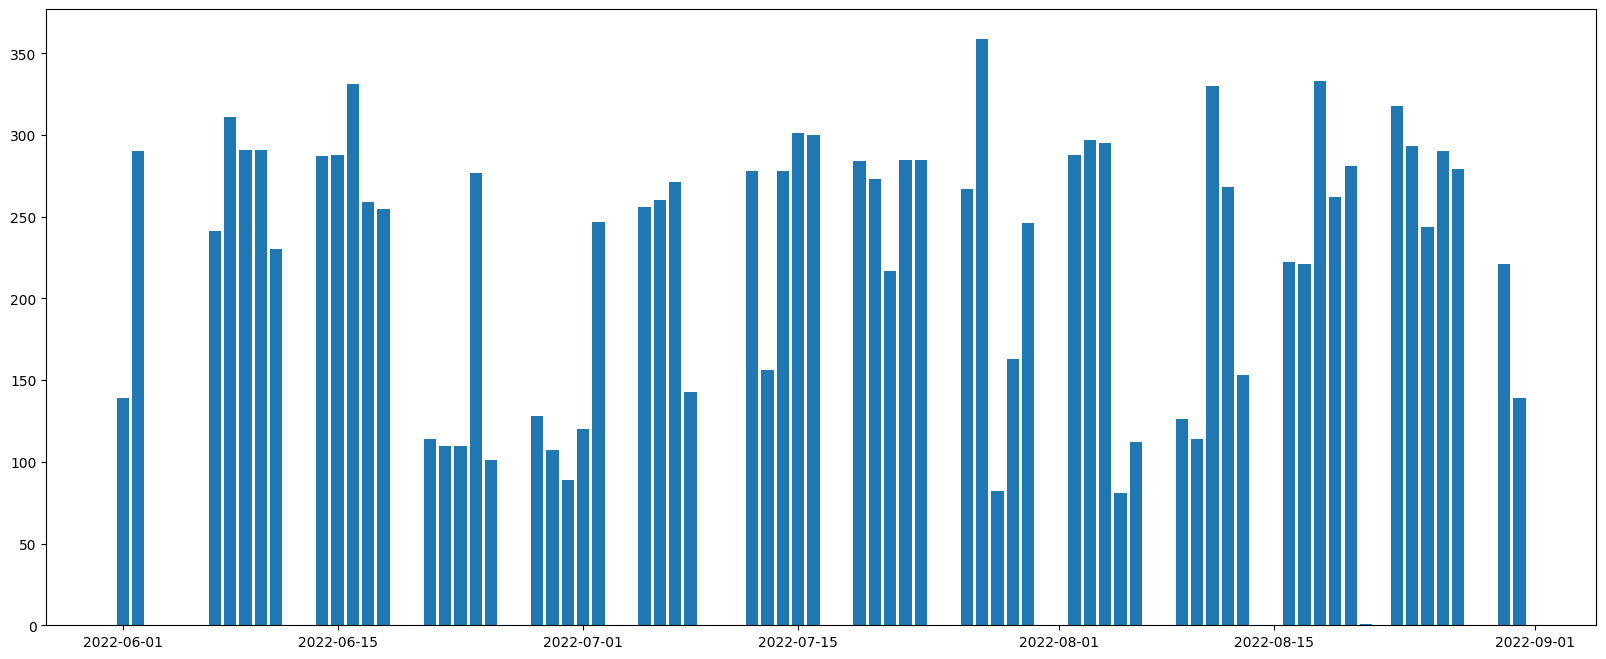

In [7]:
# volumes_totais_diarios['Volume'].plot(kind='bar', figsize = (15,8));
plt.rcParams["figure.figsize"] = (20,8)
plt.bar(volumes_totais_diarios['Data'], volumes_totais_diarios['Volume'])

## Media Movel

### Escolhendo melhor numero de janela para a media movel (baseado no erro)

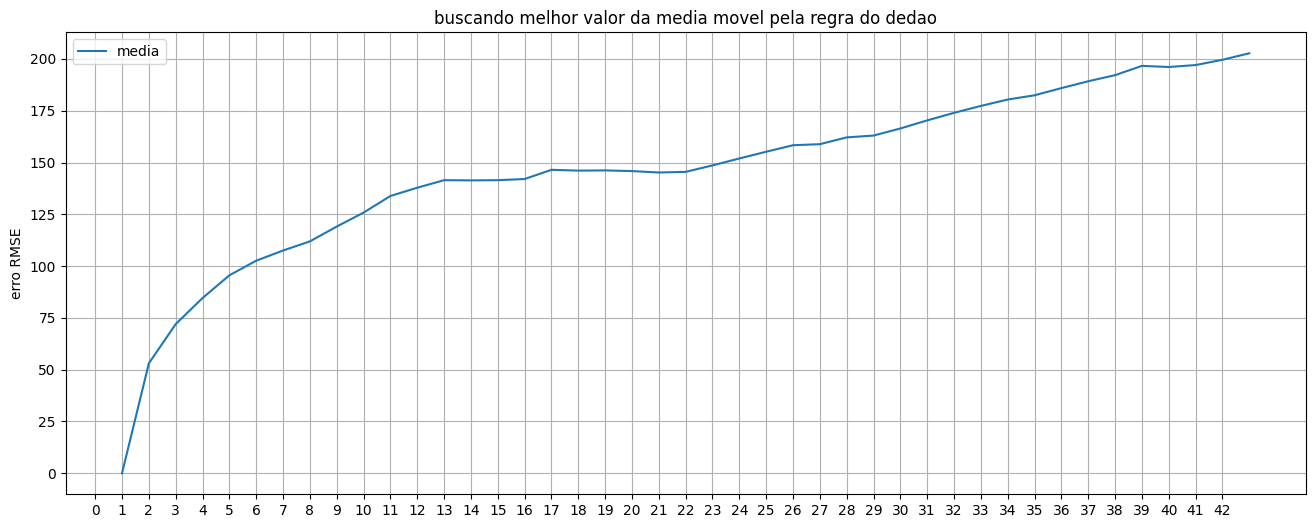

In [9]:
plt.rcParams["figure.figsize"] = (16,6)

erros_MA_diario = moving_average_test(volumes_totais_diarios)

plt.plot(erros_MA_diario.n_window, erros_MA_diario.RMSE)
plt.xticks([i for i in range(erros_MA_diario.shape[0])])
plt.legend(loc= 'best',labels = ['media', 'mediana'])
plt.ylabel('erro RMSE')
plt.title('buscando melhor valor da media movel pela regra do dedao')
plt.grid(visible=True, which = 'both')

plt.show()



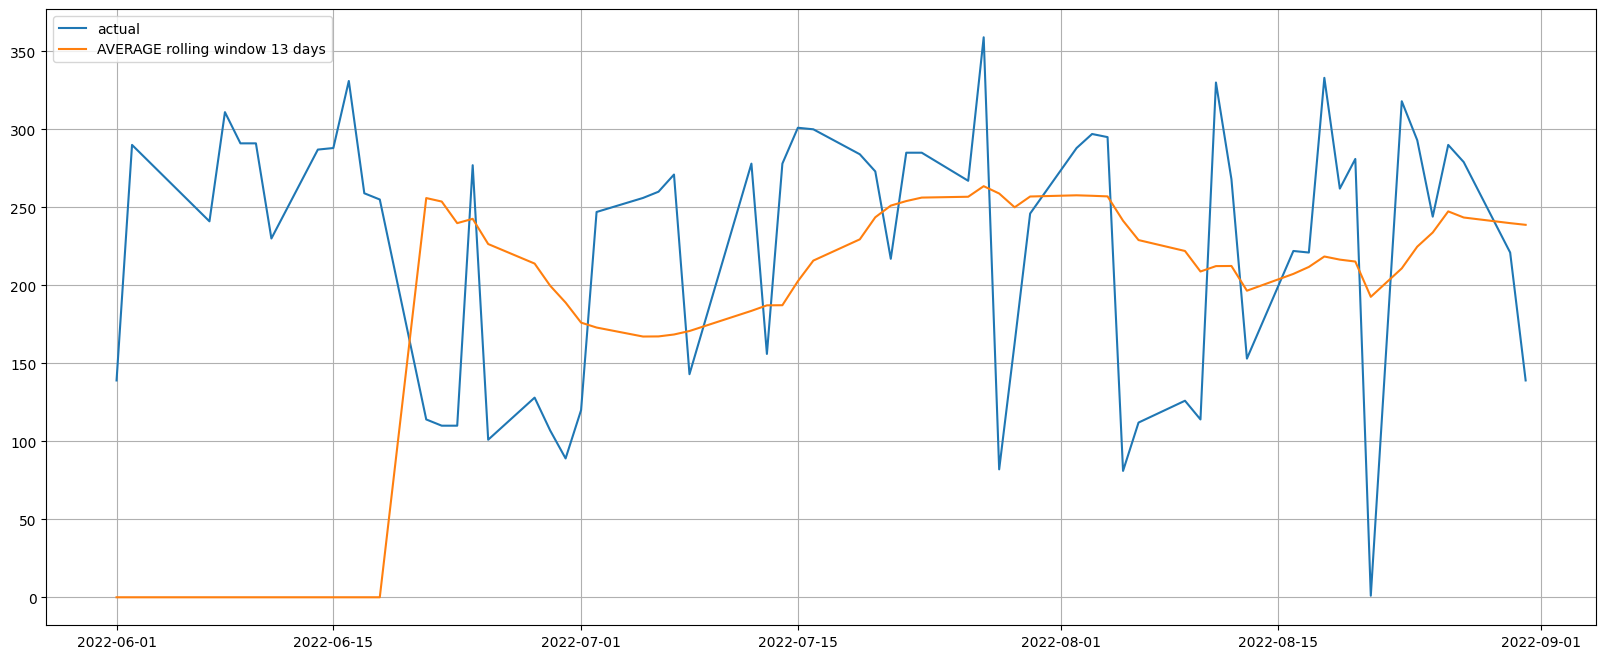

In [10]:
parametro = 13

volumes_totais_diarios['media_movel_' + str(parametro)] = volumes_totais_diarios['Volume'].rolling(parametro).mean().fillna(0)
plt.rcParams["figure.figsize"] = (20,8)

plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['Volume'])
plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['media_movel_' + str(parametro)])
plt.grid(visible=True)

# volumes_totais_diarios['mediana_movel_' + str(parametro)] = volumes_totais_diarios['Volume'].rolling(parametro).median()
# plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['mediana_movel_' + str(parametro)], color = 'purple')

plt.legend(loc = 'upper left', labels = ['actual', 'AVERAGE rolling window {} days'.format(parametro), 'MEDIAN rolling window {} days'.format(parametro)])


plt.show()

### Modelagem Media Movel

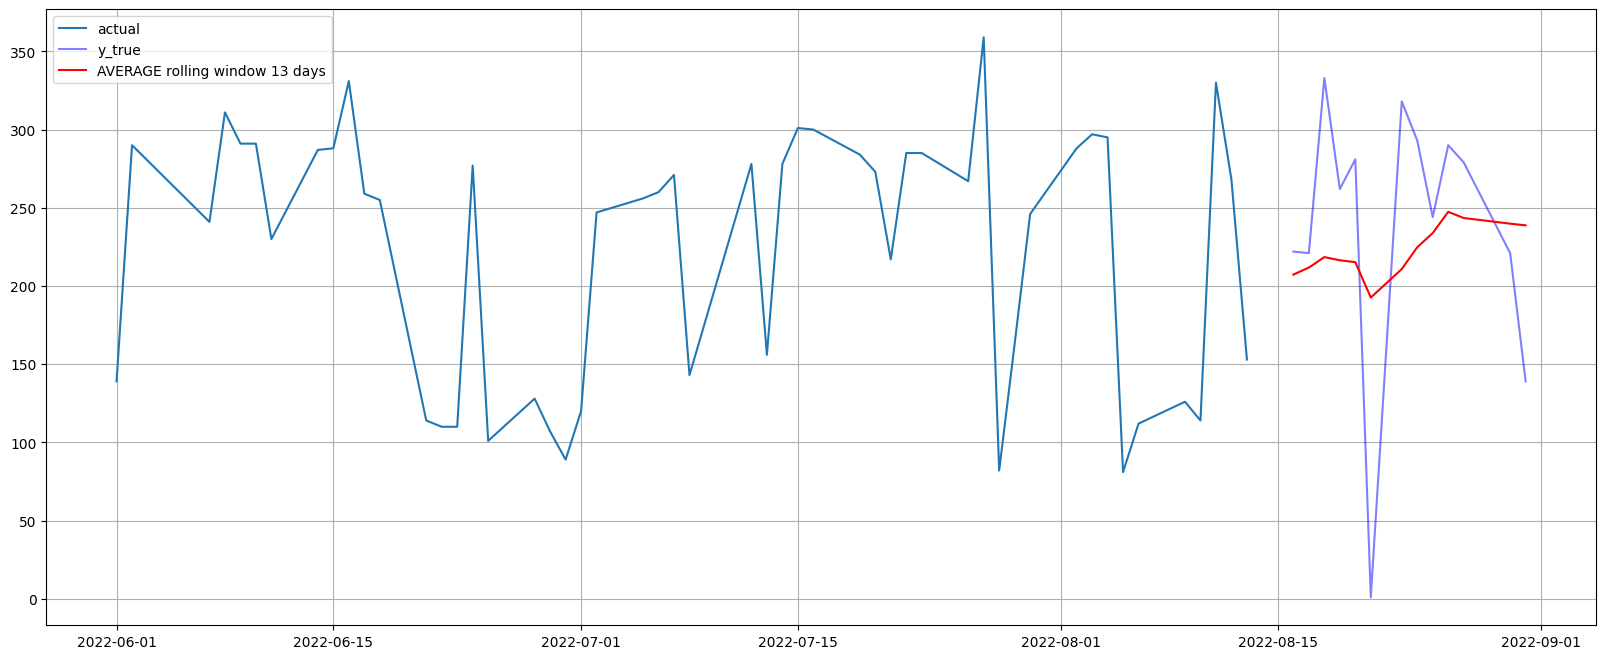

In [11]:
plt.rcParams["figure.figsize"] = (20,8)

plt.plot(volumes_totais_diarios[:volumes_totais_diarios.shape[0]-parametro]['Data'], volumes_totais_diarios[:volumes_totais_diarios.shape[0]-parametro]['Volume'])
plt.plot(volumes_totais_diarios[-parametro:]['Data'], volumes_totais_diarios[-parametro:]['Volume'],color = 'blue', alpha = 0.5)
# plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['Volume'])
plt.plot(volumes_totais_diarios[-parametro:]['Data'], volumes_totais_diarios[-parametro:]['media_movel_' + str(parametro)],color = 'red')
plt.grid(visible=True)

# volumes_totais_diarios['mediana_movel_' + str(parametro)] = volumes_totais_diarios['Volume'].rolling(parametro).median()
# plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['mediana_movel_' + str(parametro)], color = 'purple')

plt.legend(loc = 'upper left', labels = ['actual','y_true' , 'AVERAGE rolling window {} days'.format(parametro)])


plt.show()

### calculo do erro

In [12]:
print('erro (RMSE) da modelagem \t',
         mean_squared_error(volumes_totais_diarios['Volume'],
                            volumes_totais_diarios['media_movel_' + str(parametro)],
                            squared=False))

print('erro (RMSE) da previsao \t',
         mean_squared_error(volumes_totais_diarios[-parametro:]['Volume'],
                            volumes_totais_diarios[-parametro:]['media_movel_' + str(parametro)],
                            squared=False))



erro (RMSE) da modelagem 	 141.4673241094228
erro (RMSE) da previsao 	 81.41278692738923


## Suavizacao Exponencial


In [13]:
X_train,X_test  = volumes_totais_diarios[['Data', 'Volume']][:41], volumes_totais_diarios[['Data', 'Volume']][41:]

X_train.shape

(41, 2)

In [14]:
X_test.shape

(23, 2)

[217.39111918 217.39111918 217.39111918 217.39111918 217.39111918
 217.39111918 217.39111918 217.39111918 217.39111918 217.39111918
 217.39111918 217.39111918 217.39111918 217.39111918 217.39111918
 217.39111918 217.39111918 217.39111918 217.39111918 217.39111918
 217.39111918 217.39111918 217.39111918]


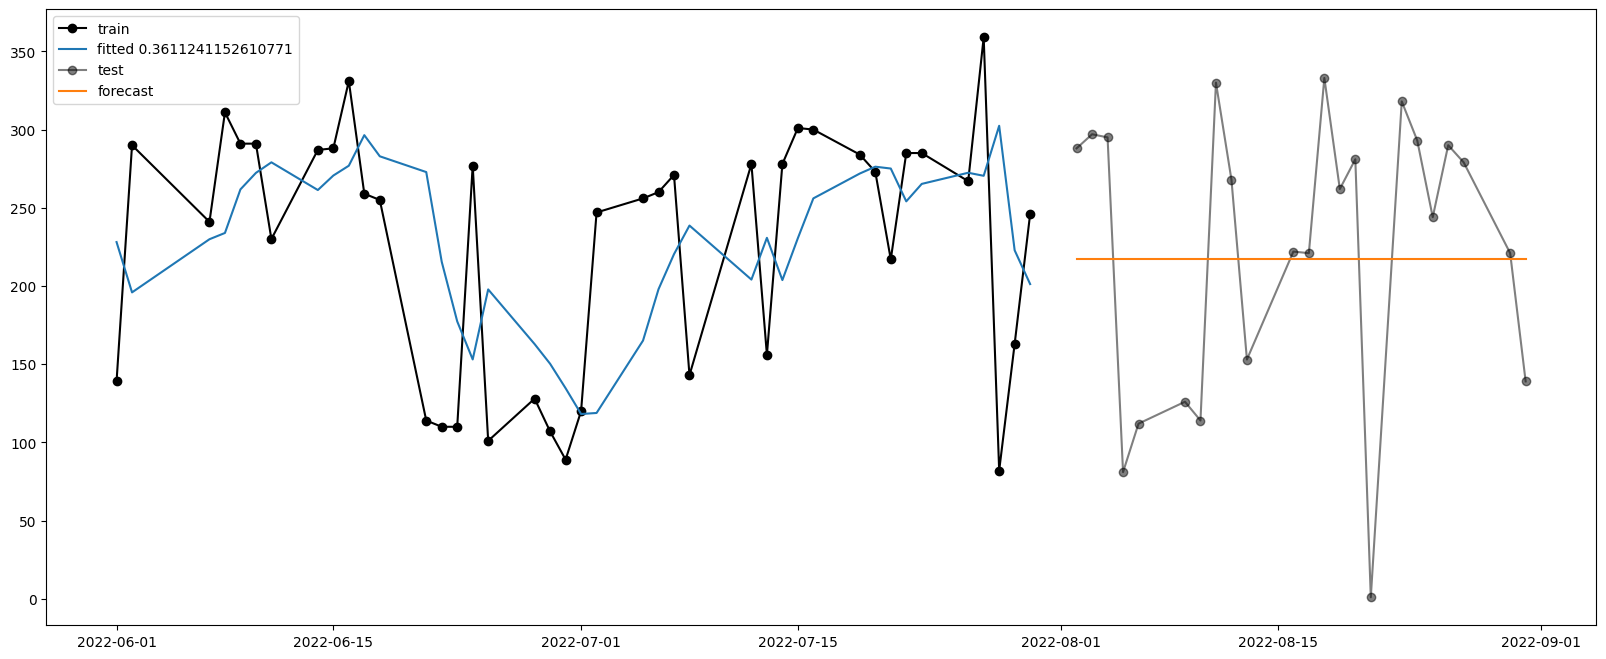

In [15]:
plt.figure(figsize=(20, 8))

fit1 = SimpleExpSmoothing(X_train['Volume'].values, initialization_method="heuristic").fit()
# X_test = pd.concat([X_test, fit1.forecast(23)], ignore_index = True)

# X_train['SESfit1'] = fit1.fittedvalues

plt.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")
plt.plot(X_train['Data'],fit1.fittedvalues)
plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)
plt.plot(X_test['Data'],fit1.forecast(23))
print(fit1.forecast(23))

plt.legend(loc = 'upper left', labels = ['train', 'fitted {}'.format(fit1.model.params["smoothing_level"]), 'test', 'forecast'])

plt.show();


### calculo do erro

In [16]:
print('erro (RMSE) da modelagem \t',
         mean_squared_error(X_train['Volume'],fit1.fittedvalues,
                            squared=False))

print('erro (RMSE) da previsao \t',
         mean_squared_error(X_test['Volume'],fit1.forecast(23),
                            squared=False))



erro (RMSE) da modelagem 	 75.54146414596443
erro (RMSE) da previsao 	 89.32599364037493


In [17]:
### MEDIA PERFORMA MELHOR QUE SUAVIZACAO EXPONENCIAL MAIS APURADA

mean_squared_error(X_train['Volume'],np.array([volumes_totais_diarios['Volume'].mean() for i in range(X_train.shape[0])]),squared=False)


77.99769628008254

## Metodo de Holt

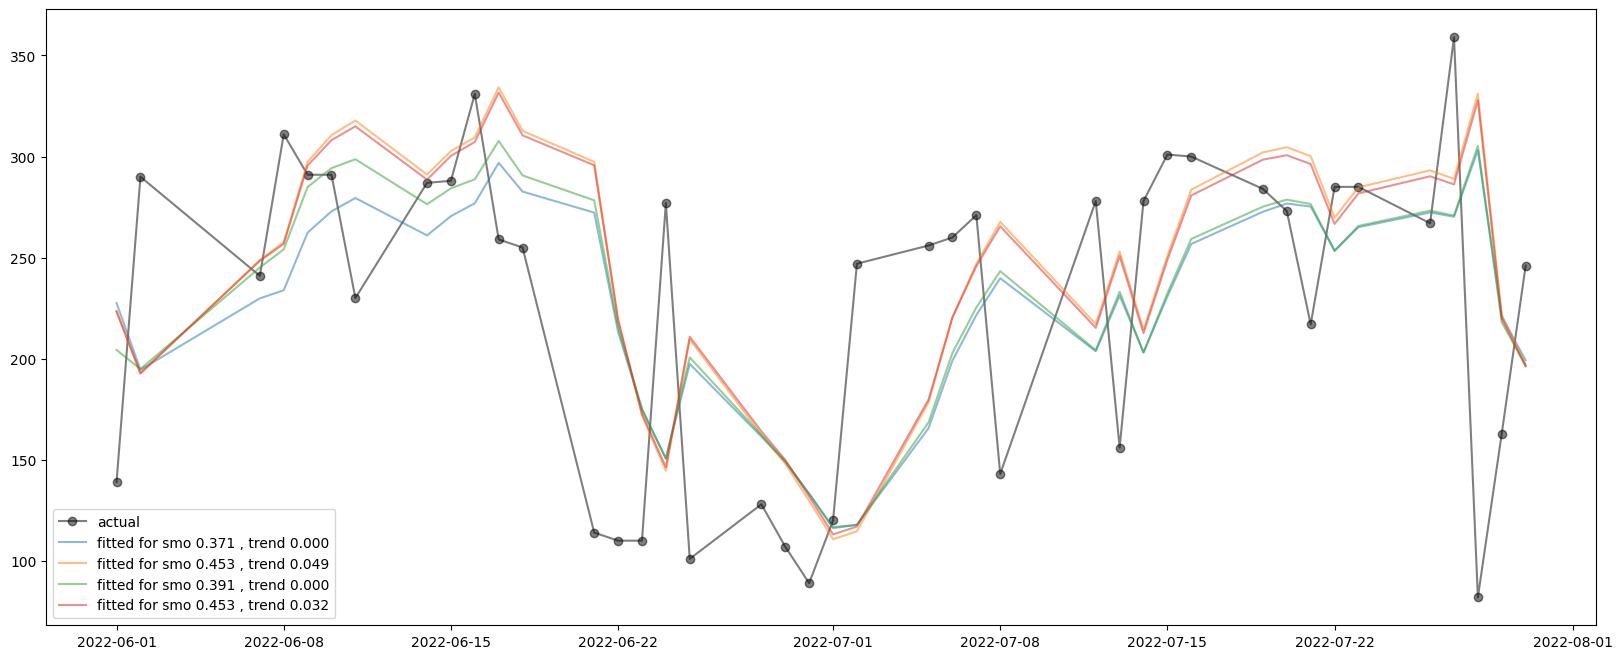

In [18]:
plt.figure(figsize=(20, 8))

fit_holts1 = Holt(X_train['Volume'].values, initialization_method="estimated").fit(optimized=True)

fit_holts2 = Holt(X_train['Volume'].values, exponential=True, initialization_method="estimated").fit(optimized=True)

fit_holts3 = Holt(X_train['Volume'].values, damped_trend=True, initialization_method="estimated").fit(optimized=True)

fit_holts4 = Holt(X_train['Volume'].values,exponential=True, damped_trend=True, initialization_method="estimated").fit(optimized=True)


plt.plot(X_train['Data'],X_train['Volume'].values, marker="o", color="black", alpha = 0.5)

plt.plot(X_train['Data'],fit_holts1.fittedvalues,   alpha = 0.5)
plt.plot(X_train['Data'],fit_holts2.fittedvalues,   alpha = 0.5)
plt.plot(X_train['Data'],fit_holts3.fittedvalues,   alpha = 0.5)
plt.plot(X_train['Data'],fit_holts4.fittedvalues,   alpha = 0.5)

plt.legend(loc = 'lower left', labels = ['actual', 
                                'fitted for smo {:.3f} , trend {:.3f}'.format(fit_holts1.model.params["smoothing_level"], fit_holts1.model.params["smoothing_trend"]),
                                'fitted for smo {:.3f} , trend {:.3f}'.format(fit_holts2.model.params["smoothing_level"], fit_holts2.model.params["smoothing_trend"]),
                                'fitted for smo {:.3f} , trend {:.3f}'.format(fit_holts3.model.params["smoothing_level"], fit_holts3.model.params["smoothing_trend"]),
                                'fitted for smo {:.3f} , trend {:.3f}'.format(fit_holts4.model.params["smoothing_level"], fit_holts4.model.params["smoothing_trend"])
                                
                                ])

plt.show();

In [19]:
print('exponential, Type of trend component.', end= '\n')
print('damped_trend, Should the trend component be damped.', end= '\n')
print()
print('erro (RMSE) da modelagem (fit otimizado = otimos / sem parametros)\t', mean_squared_error(X_train['Volume'],fit_holts1.fittedvalues, squared=False))
print('erro (RMSE) da modelagem (fit otimizado = otimos / exponential=True)\t', mean_squared_error(X_train['Volume'],fit_holts2.fittedvalues, squared=False))
print('erro (RMSE) da modelagem (fit otimizado = otimos / damped_trend=True)\t', mean_squared_error(X_train['Volume'],fit_holts3.fittedvalues, squared=False))
print('erro (RMSE) da modelagem (fit otimizado = otimos / exponential=True e damped_trend=True)\t', mean_squared_error(X_train['Volume'],fit_holts4.fittedvalues, squared=False))


print('\n a melhor modelagem eh (fit otimizado = otimos / damped_trend=True)' )
 

exponential, Type of trend component.
damped_trend, Should the trend component be damped.

erro (RMSE) da modelagem (fit otimizado = otimos / sem parametros)	 75.54369280073026
erro (RMSE) da modelagem (fit otimizado = otimos / exponential=True)	 80.23092596189554
erro (RMSE) da modelagem (fit otimizado = otimos / damped_trend=True)	 75.12564422984332
erro (RMSE) da modelagem (fit otimizado = otimos / exponential=True e damped_trend=True)	 79.46778300635756

 a melhor modelagem eh (fit otimizado = otimos / damped_trend=True)


[215.84316727 215.83677142 215.83158247 215.82737266 215.82395724
 215.8211863  215.81893824 215.81711438 215.81563468 215.81443419
 215.81346024 215.81267007 215.81202901 215.81150891 215.81108695
 215.81074462 215.81046688 215.81024155 215.81005875 215.80991043
 215.80979011 215.80969249 215.80961329]


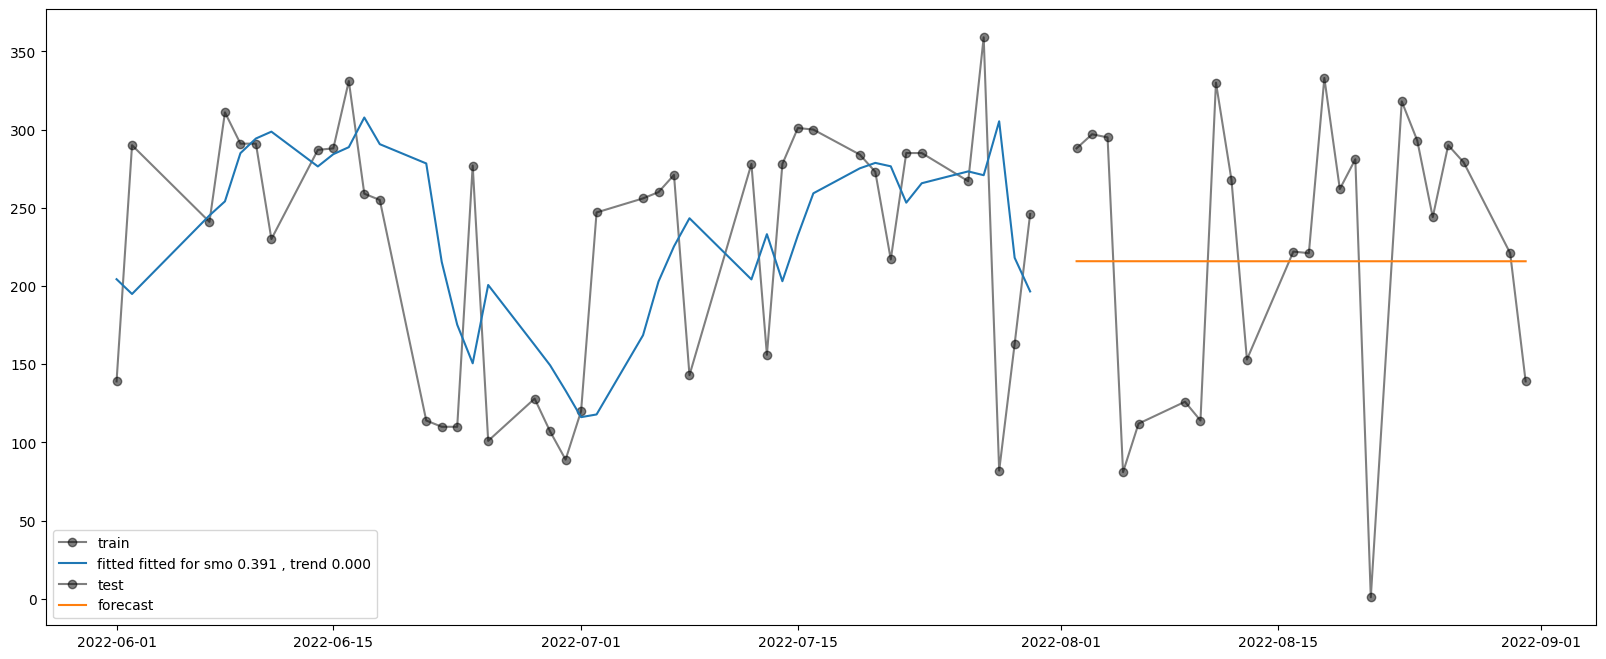

In [20]:
plt.figure(figsize=(20, 8))

fit_holts_final = Holt(X_train['Volume'].values, damped_trend=True, initialization_method="estimated").fit(optimized=True)

plt.plot(X_train['Data'],X_train['Volume'].values, marker="o", color="black", alpha = 0.5)
plt.plot(X_train['Data'],fit_holts_final.fittedvalues)
plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)
plt.plot(X_test['Data'],fit_holts_final.forecast(23))
print(fit_holts_final.forecast(23))

plt.legend(loc = 'lower left', labels = ['train',
                    'fitted {}'.format('fitted for smo {:.3f} , trend {:.3f}'.format(fit_holts_final.model.params["smoothing_level"], fit_holts_final.model.params["smoothing_trend"])),
                    'test', 'forecast'])

plt.show();


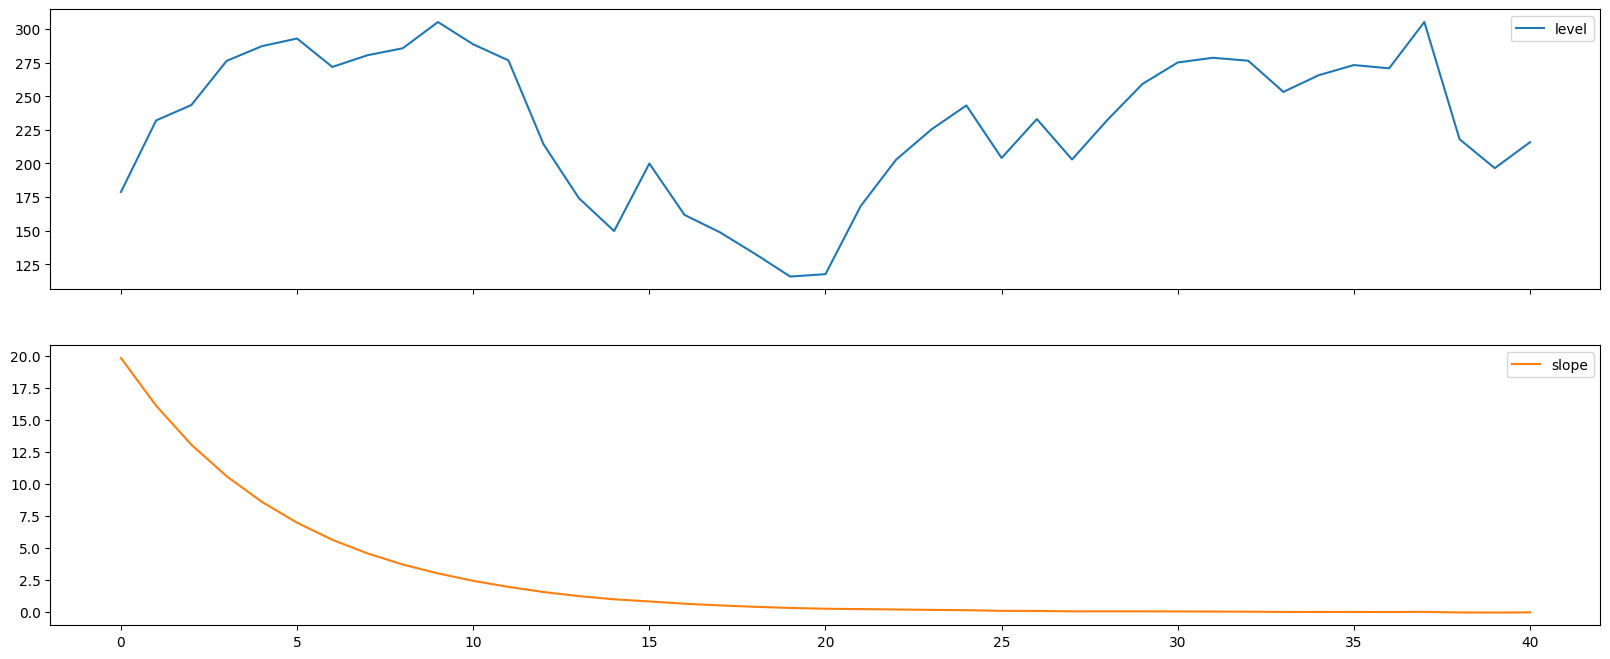

In [21]:
pd.DataFrame(np.c_[fit_holts_final.level, fit_holts_final.trend]).rename(
    columns={0: "level", 1: "slope"}
).plot(subplots=True)
plt.show()


#### como calcular o erro do metodo de holt?

O metodo de holts tem 2 hyperparametros serem ajustados, mas tambem uma serie de metodos de calculo que variam os resultados
 - exponential=True
 - damped_trend=True
 - entre outros 

In [22]:
print('erro (RMSE) da modelagem \t',
         mean_squared_error(X_train['Volume'],fit_holts_final.fittedvalues,
                            squared=False))

print('erro (RMSE) da previsao \t',
         mean_squared_error(X_test['Volume'],fit_holts_final.forecast(23),
                            squared=False))



erro (RMSE) da modelagem 	 75.12564422984332
erro (RMSE) da previsao 	 89.46832687254764


## Metodo de Holt Winters

### escolha dos parametros

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


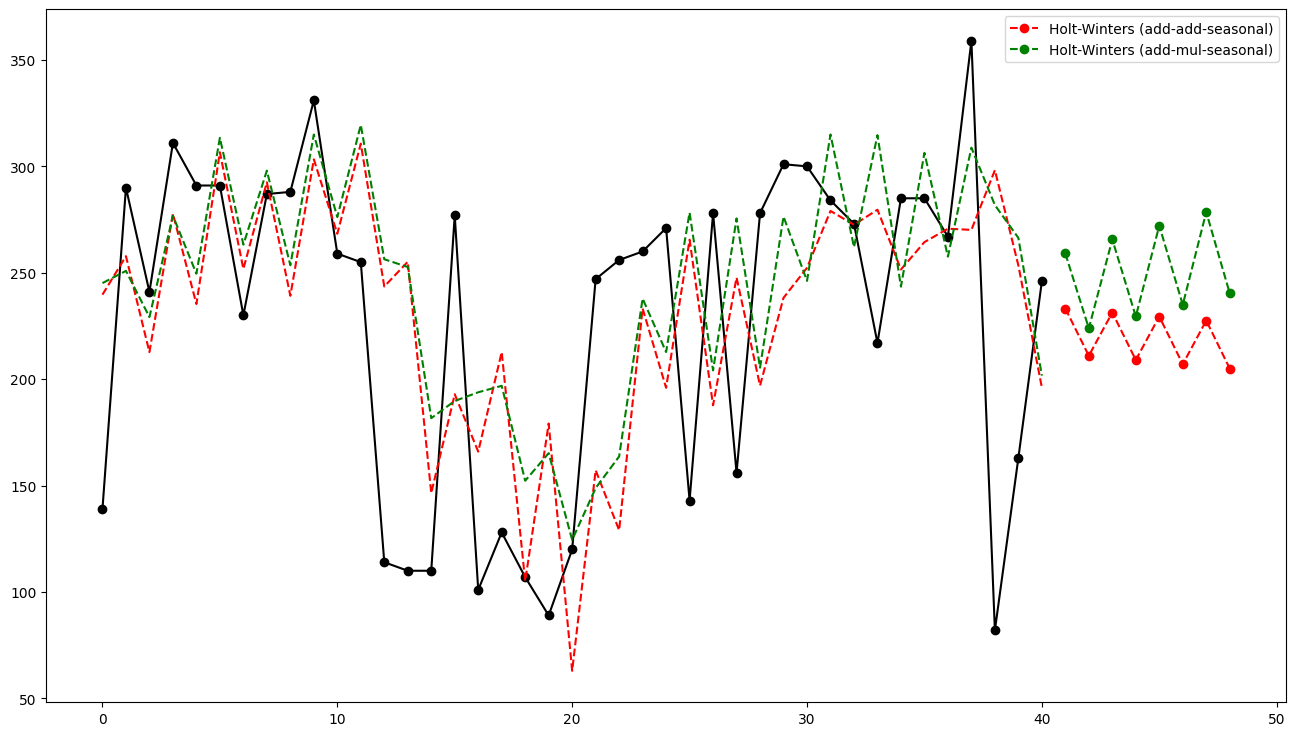

melhor desempenho fica com multiplicative WH damped, mas por muito pouco


Additive  Multiplicative  Additive Dam  Multiplica Dam
$\alpha$     0.322612        0.358571      0.325207        0.358571
$\beta$      0.000700        0.000100      0.000100        0.000100
$\phi$            NaN             NaN      0.989440        0.990000
$\gamma$     0.088190        0.000100      0.087757        0.000100
$l_0$     5746.920811     5754.481867   5742.590067     5754.481867
$b_0$      -30.838784      104.571160    -48.119789      104.571160
RMSE        76.192592       75.694386     76.175591       75.415384

In [23]:
WH1 = ExponentialSmoothing(X_train['Volume'],seasonal_periods=2,trend="add",seasonal="add",use_boxcox=True,initialization_method="estimated").fit()
WH2 = ExponentialSmoothing(X_train['Volume'],seasonal_periods=2,trend="add",seasonal="mul",use_boxcox=True,initialization_method="estimated").fit()
WH3 = ExponentialSmoothing(X_train['Volume'],seasonal_periods=2,trend="add",seasonal="add",damped_trend=True,use_boxcox=True,initialization_method="estimated").fit()
WH4 = ExponentialSmoothing(X_train['Volume'],seasonal_periods=2,trend="add",seasonal="mul",damped_trend=True,use_boxcox=True,initialization_method="estimated").fit()

erros_WH = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "RMSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
erros_WH["Additive"] = [WH1.params[p] for p in params] +        [mean_squared_error(X_train['Volume'],WH1.fittedvalues, squared=False)]
erros_WH["Multiplicative"] = [WH2.params[p] for p in params] +  [mean_squared_error(X_train['Volume'],WH2.fittedvalues, squared=False)]
erros_WH["Additive Dam"] = [WH3.params[p] for p in params] +    [mean_squared_error(X_train['Volume'],WH3.fittedvalues, squared=False)]
erros_WH["Multiplica Dam"] = [WH4.params[p] for p in params] +  [mean_squared_error(X_train['Volume'],WH4.fittedvalues, squared=False)]

ax = X_train['Volume'].plot(figsize=(16, 9),marker="o",color="black")

WH1.fittedvalues.plot(ax=ax, style="--", color="red")
WH2.fittedvalues.plot(ax=ax, style="--", color="green")

WH1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)
WH2.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)

plt.show()
print('melhor desempenho fica com multiplicative WH damped, mas por muito pouco')

erros_WH

### modelagem

41    255.974064
42    220.289746
43    260.272172
44    223.901717
45    264.440993
46    227.405882
47    268.486324
48    230.807006
49    272.413546
50    234.109520
51    276.227672
52    237.317552
53    279.933377
54    240.434964
55    283.535039
56    243.465368
57    287.036760
58    246.412158
59    290.442392
60    249.278523
61    293.755564
62    252.067468
63    296.979695
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


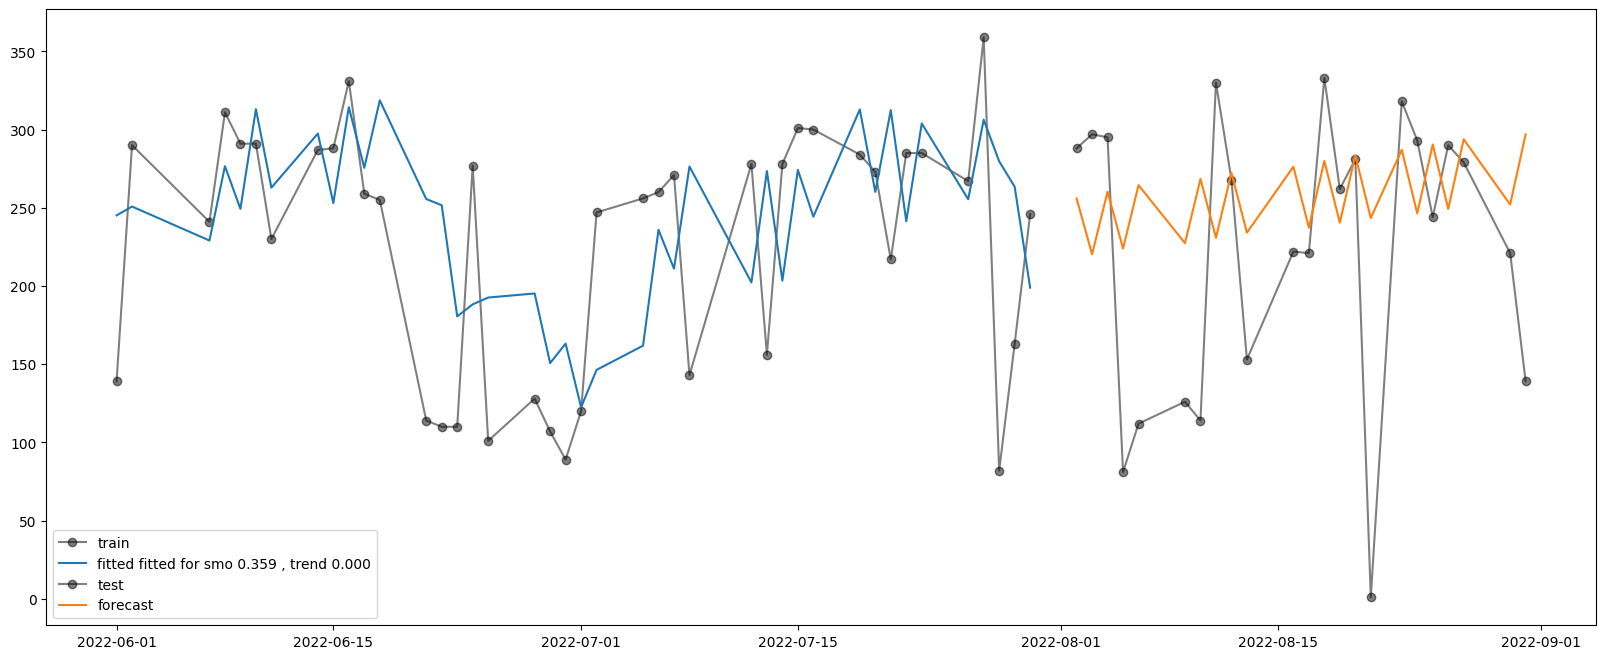

In [24]:
plt.figure(figsize=(20, 8))

WH4 = ExponentialSmoothing(X_train['Volume'],seasonal_periods=2,trend="add",seasonal="mul",damped_trend=True,use_boxcox=True,initialization_method="estimated").fit()

plt.plot(X_train['Data'],X_train['Volume'].values, marker="o", color="black", alpha = 0.5)
plt.plot(X_train['Data'],WH4.fittedvalues)
plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)
plt.plot(X_test['Data'],WH4.forecast(23))
print(WH4.forecast(23))

plt.legend(loc = 'lower left', labels = ['train',
                    'fitted {}'.format('fitted for smo {:.3f} , trend {:.3f}'.format(WH4.model.params["smoothing_level"], WH4.model.params["smoothing_trend"])),
                    'test', 'forecast'])

plt.show();


In [25]:
print('erro (RMSE) da modelagem \t',
         mean_squared_error(X_train['Volume'],WH4.fittedvalues,
                            squared=False))

print('erro (RMSE) da previsao \t',
         mean_squared_error(X_test['Volume'],WH4.forecast(23),
                            squared=False))



erro (RMSE) da modelagem 	 75.4153840928871
erro (RMSE) da previsao 	 93.4206584317169


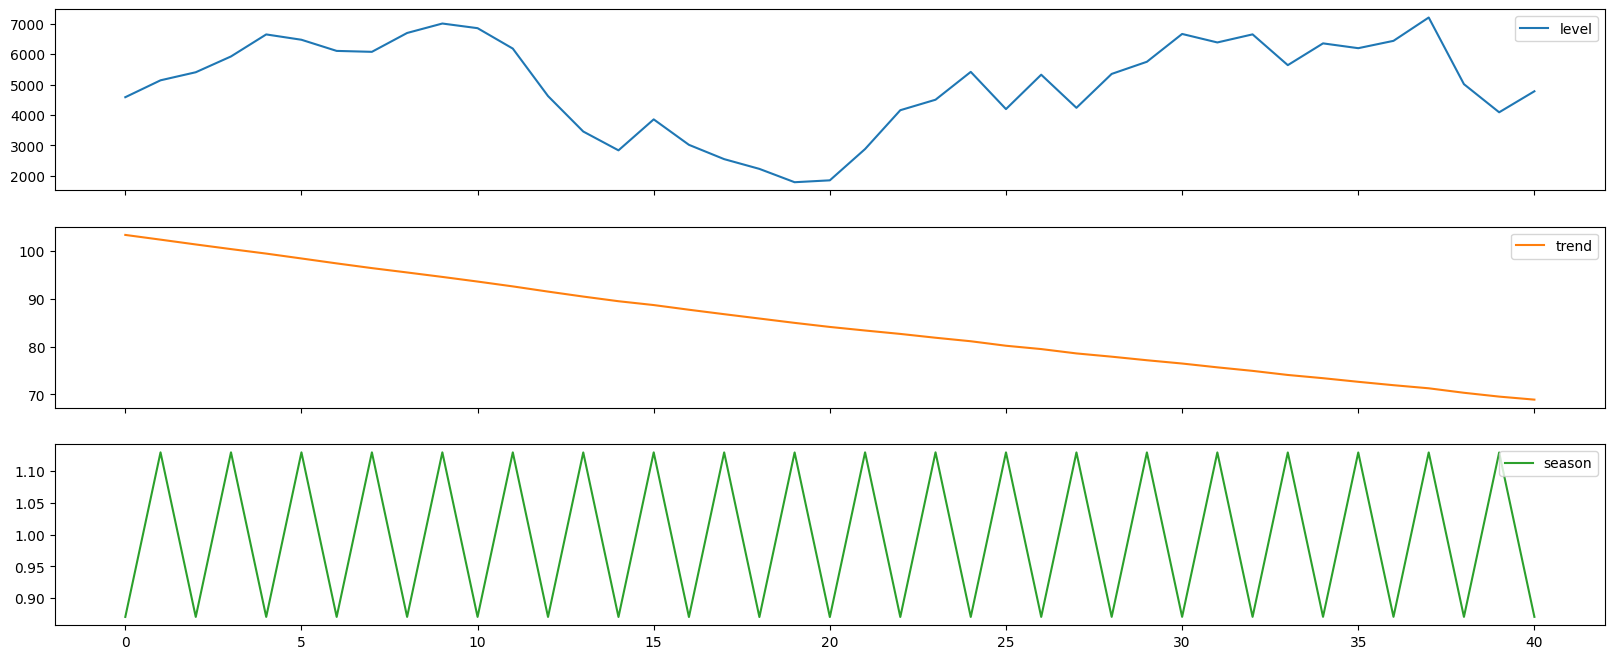

In [26]:
pd.DataFrame(np.c_[WH4.level, WH4.trend, WH4.season]).rename(
    columns={0: "level", 1: "trend", 2:"season"}
).plot(subplots=True)
plt.show()


## ARIMA

In [27]:

# from prophet import Prophet

### Determinação dos parâmetros do ARIMA

#### Checar se a série é estacionária
A série estacionária é condição _sine qua non_ para a aplicação do método; caso nao for, é possível utilizar a diferenciação da série - quantas vezes forem necessárias -  para torná-la estacionária. Escolhido o radar, observa-se se a série pode ser considerada estacionária (p-value inferior a 0.05) por meio do teste de Dickey-Fuller aumentado (ADF).

In [28]:
result = adfuller(X_train.Volume)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.331597
p-value: 0.000391


In [29]:
X_train.head()



Data  Volume
0 2022-06-01     139
1 2022-06-02     290
2 2022-06-07     241
3 2022-06-08     311
4 2022-06-09     291

#### Validação Visual

Para validar visualmente o resultado do teste ADF, plotamos funções de autocorrelação para a série original, com diferenciação de primeira e de segunda ordem. 

Espera-se que a série original tenha uma curva da Função de Autocorrelação (ACF) decrescente enquanto as outras possuam uma queda abrupta pois, segundo o teste ADF, elas já serão diferenciadas.

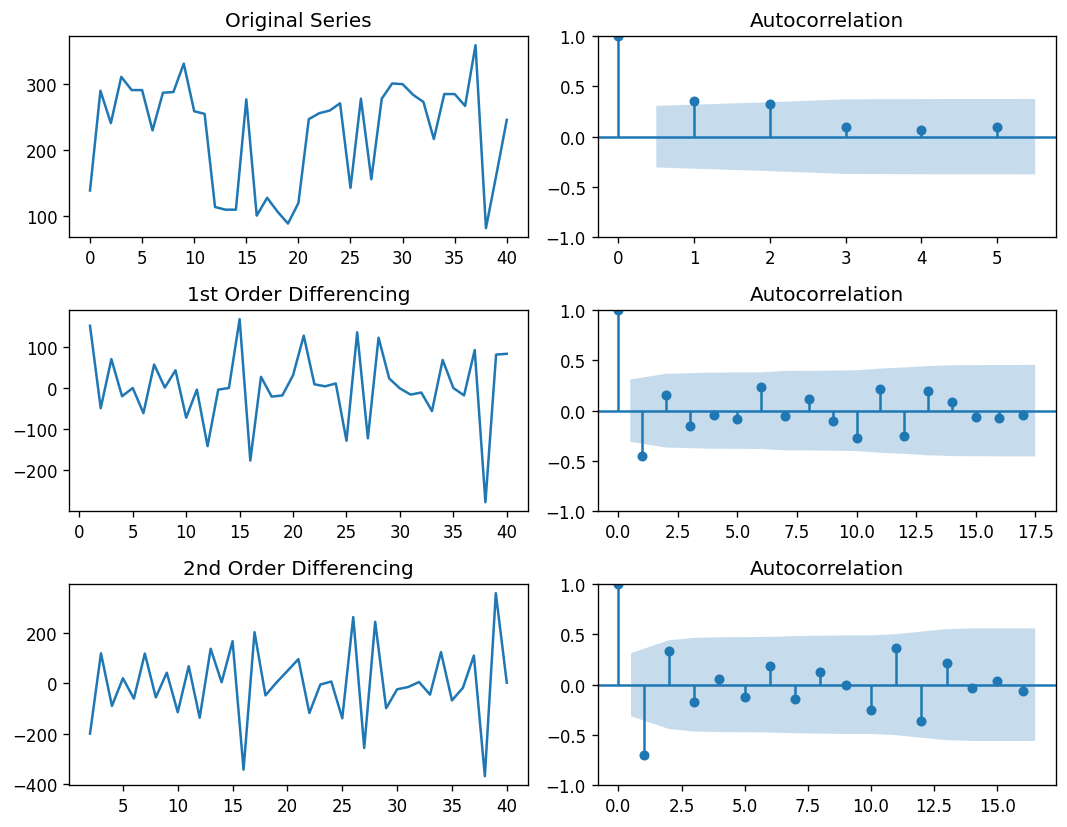

In [30]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
fig, axes = plt.subplots(3, 2, sharex=False)

# Original Series
axes[0, 0].plot(X_train.Volume); axes[0, 0].set_title('Original Series')
plot_acf(X_train.Volume, ax=axes[0, 1], alpha=0.05, lags=5)

# 1st Differencing
axes[1, 0].plot(X_train.Volume.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(X_train.Volume.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(X_train.Volume.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(X_train.Volume.diff().diff().dropna(), ax=axes[2, 1])

plt.tight_layout()
plt.show()

Os plots mostram que na primeira diferenciação, a série já se torna super diferenciada (o que pode ser notado pela queda abrupta na curva de autocorrelação). Isso indica que o parâmetro d=0 é realmente o ideal

#### Ordem da Auto-Regressão

Por se tratar de uma regressão feita sobre os valores anteriores da série, deve-se ver até que ponto há correlação entre os pontos de observação. Isso é definido através da Função de Autocorrelação Parcial (PACF).

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


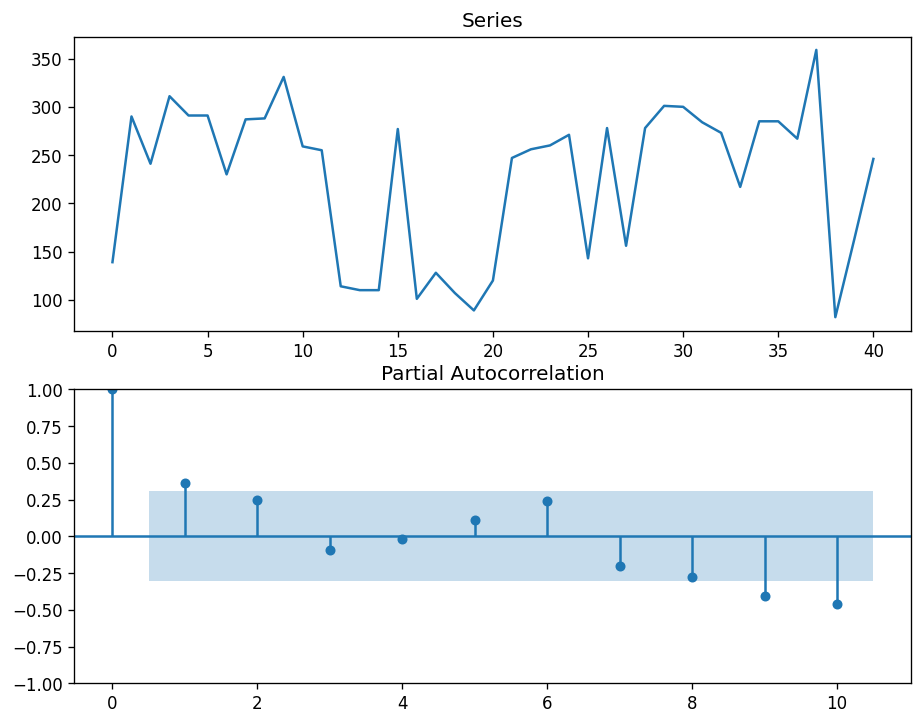

In [31]:
# PACF
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(2, 1, sharex=False)
axes[0].plot(X_train.Volume); axes[0].set_title('Series')
axes[1].set(ylim=(0,1.05))
plot_pacf(X_train.Volume, ax=axes[1], lags= 10)

plt.show()

#### Ordem da Média-Móvel

O plot da ACF fornece um threshold, um limite, superior para o ordem do modelo MA. 

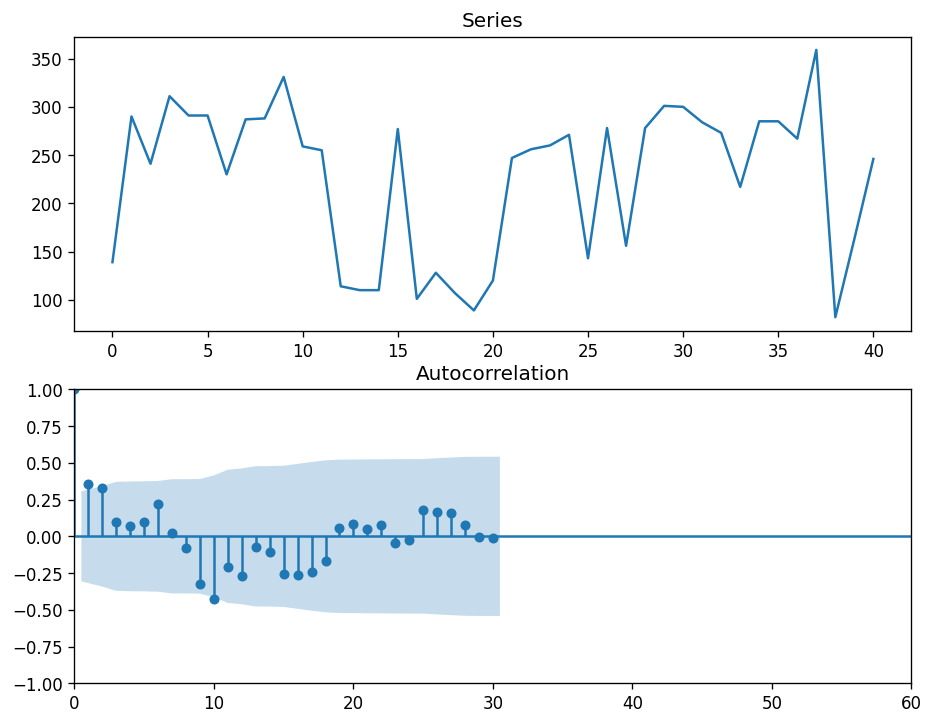

In [32]:
fig, axes = plt.subplots(2,1, sharex=False)


axes[0].plot(X_train.Volume); axes[0].set_title('Series')
axes[1].set(ylim=(0,1.2), xlim=(0,60))
plot_acf(X_train.Volume, ax=axes[1], lags=30)


# plt.annotate('Entra na área de significância', xytext=(30, 1),xy=(43,0.4),arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

A autocorrelação decai muito lentamente para a série em questão. 


Isso nos daria um treshold máximo da ordem de 40. No entanto, vale ressaltar que esse valor pode ser muito elevado, então deve-se sempre levar em conta tanto o fator de **performance do modelo** quanto **custo computacional**, evitando o uso de parâmetros muito elevados em quaisquer modelos.

Nos modelos ARIMA, a componente de média móvel raramente ultrapassa 3 ou 4. Por isso, utilizaremos o valor 1 para manter o modelo simples.

In [33]:
p = 1 #Autoregressao
d = 1 #Diferenciacao
q = 1 #MediaMovel
steps = 5 # Steps a serem previstos

teste=X_test[:steps]

# Instancia o modelo e faz o fit no treino
model = ARIMA(X_test['Volume'],order=(p,d,q))
model_fit=model.fit()

# Realiza FORECAST
fc = model_fit.predict(steps, alpha=0.05)  # 95% conf
fc


46    201.318588
47    190.999760
48    178.987293
49    223.064120
50    220.489827
51    200.168046
52    210.357455
53    211.104502
54    233.681194
55    227.171163
56    232.966876
57    185.223818
58    230.828010
59    231.238629
60    226.039058
61    234.695657
62    235.461848
63    227.874646
Name: predicted_mean, dtype: float64

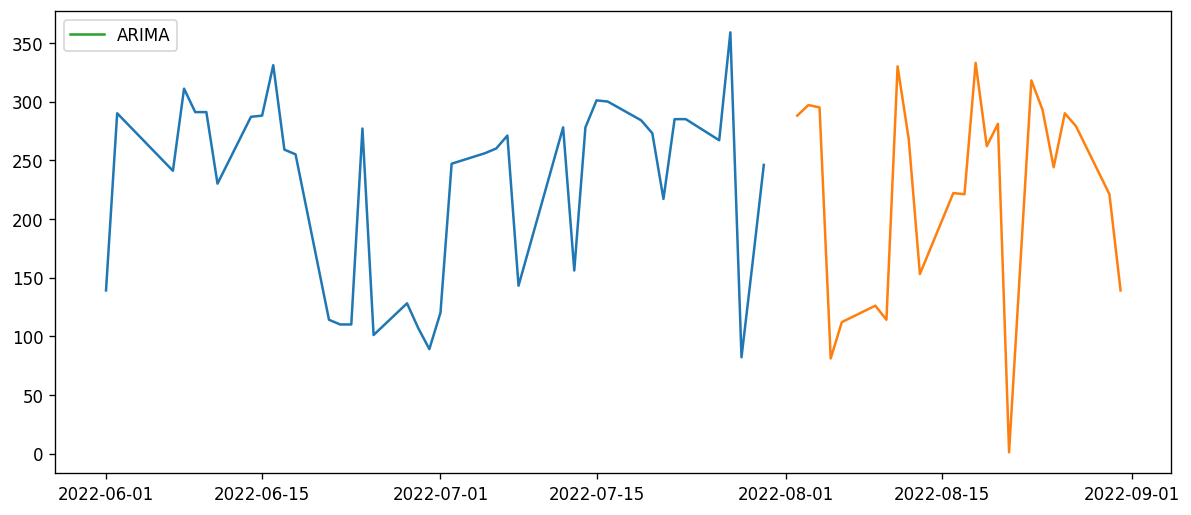

In [34]:
fc_series = pd.Series(fc, index=teste.index)

# lower_series = pd.Series(conf[:, 0], index=teste.Data)
# upper_series = pd.Series(conf[:, 1], index=teste.Data)

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(X_train['Data'], X_train['Volume'])#, label='Observações de fato, usadas para treino')
ax.plot(X_test['Data'], X_test['Volume'])#, label='Comportamento de fato, após %s h'%hora)
ax.plot(X_test[-5:]['Data'], fc_series, label='ARIMA')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                   color='k', alpha=.15)

plt.legend(loc='upper left', fontsize=10)
plt.show()

In [35]:
df_train_arima = X_train.set_index('Data')

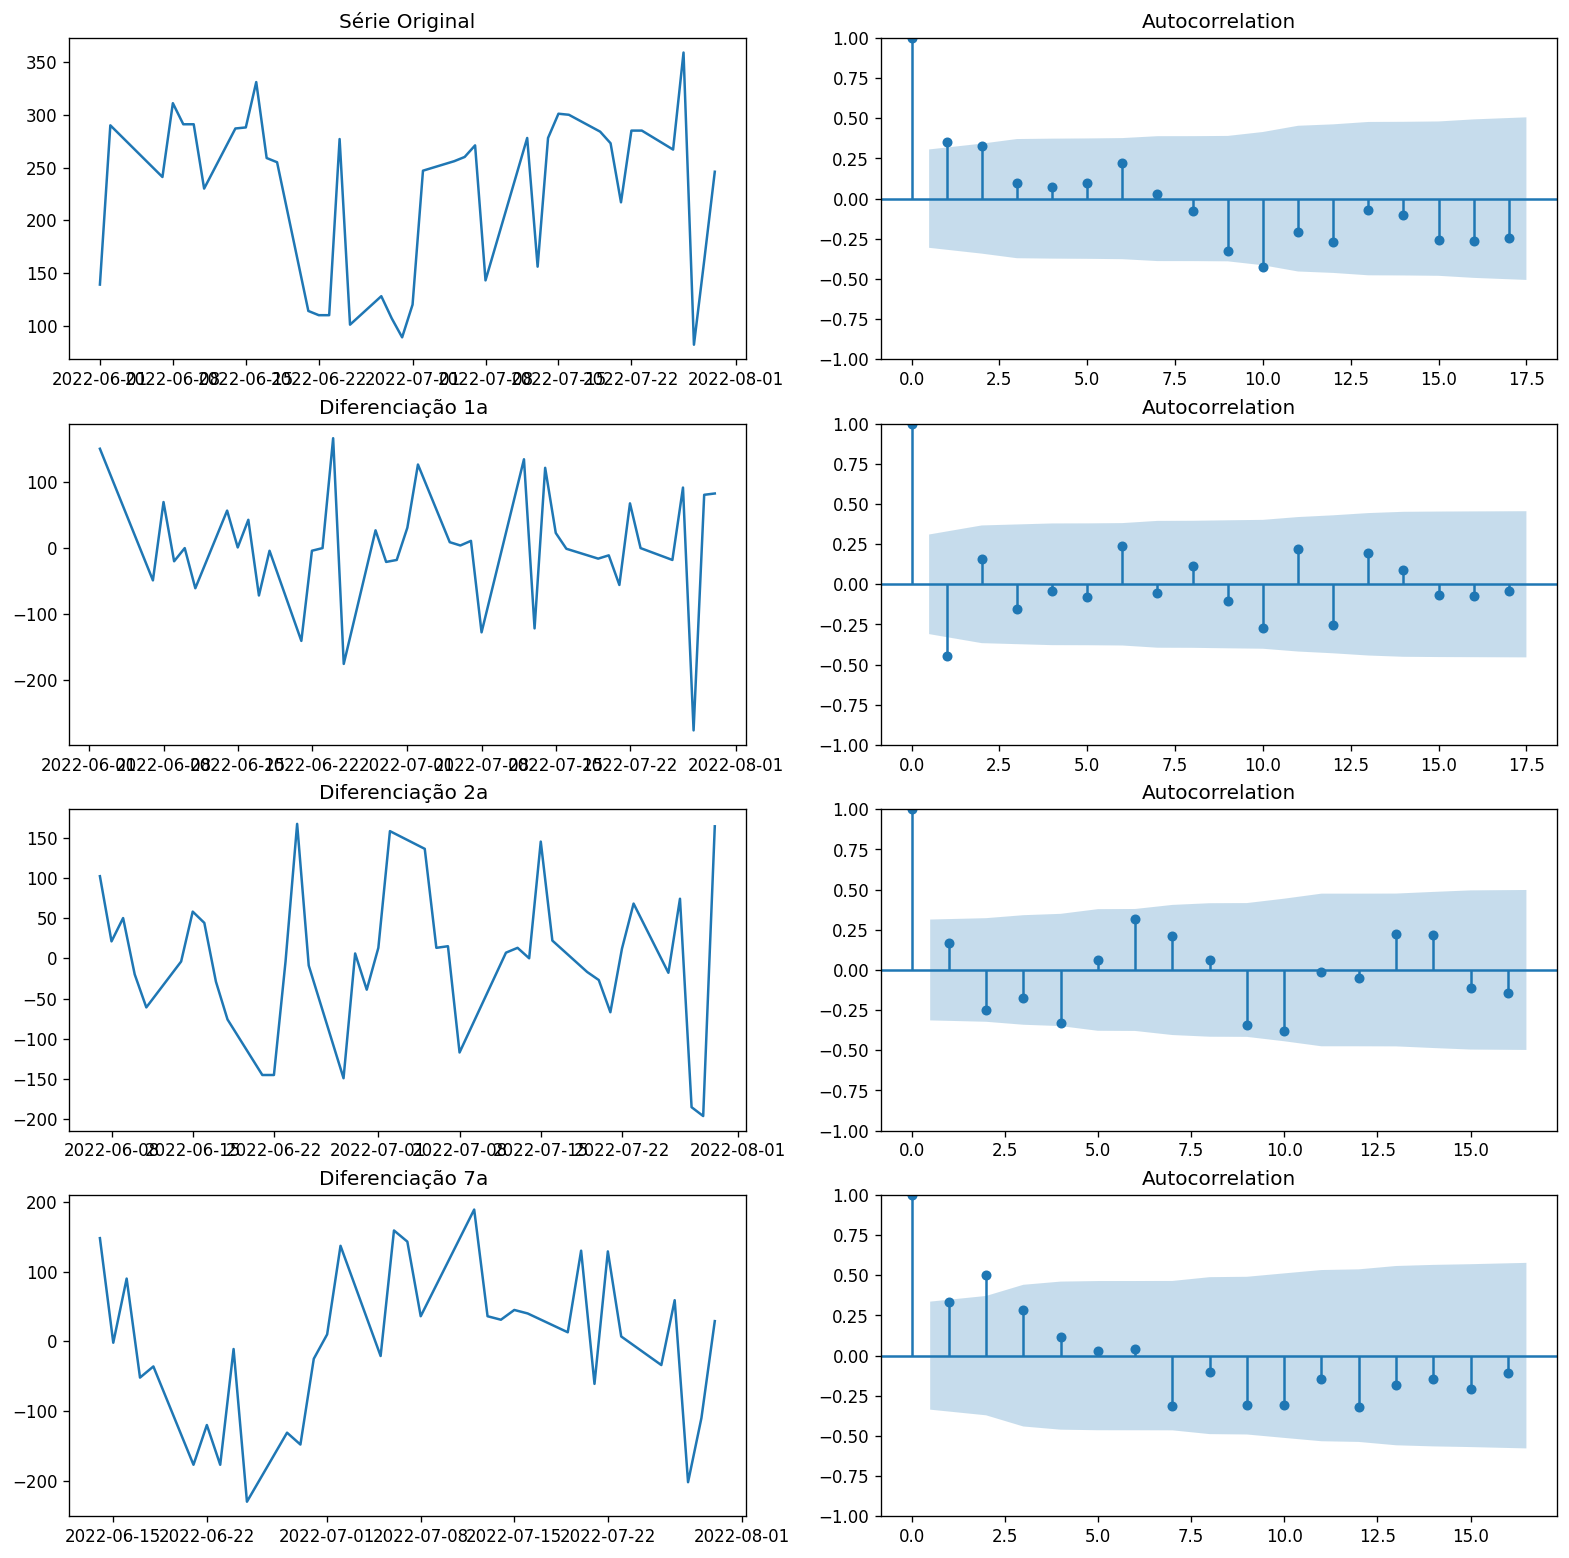

In [36]:
plt.rcParams.update({'figure.figsize':(16,16), 'figure.dpi':120})
# Série Original
fig, axes = plt.subplots(4, 2)
axes[0, 0].plot(df_train_arima); axes[0, 0].set_title('Série Original') 
plot_acf(df_train_arima, ax=axes[0, 1])
# Diferenciação 1a Ordem
axes[1, 0].plot(df_train_arima.diff()); axes[1, 0].set_title('Diferenciação 1a ')
plot_acf(df_train_arima.diff().dropna(), ax=axes[1, 1])
# Diferenciação 2a Ordem
axes[2, 0].plot(df_train_arima.diff(2)); axes[2, 0].set_title('Diferenciação 2a ')
plot_acf(df_train_arima.diff(2).dropna(), ax=axes[2, 1])
# Diferenciação 7a Ordem
axes[3, 0].plot(df_train_arima.diff(7)); axes[3, 0].set_title('Diferenciação 7a ')
plot_acf(df_train_arima.diff(7).dropna(), ax=axes[3, 1])
plt.show()

### Teste da Estacionariedade

- Teste escolhido: Augmented Dickey Fuller Test 
- Escolheu-se a de 1a ordem por já satisfazer o teste.

In [37]:
result = adfuller(df_train_arima.diff(1).dropna()) 
print('p-value: %f' % result[1])


p-value: 0.219347


In [38]:
mod = ARIMA(df_train_arima, order=(1, 0, 0))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                   41
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -234.023
Date:                Tue, 01 Nov 2022   AIC                            474.045
Time:                        12:25:00   BIC                            479.186
Sample:                             0   HQIC                           475.917
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        226.3892     20.968     10.797      0.000     185.293     267.486
ar.L1          0.3570      0.170      2.099      0.036       0.024       0.690
sigma2      5292.0931   1943.541      2.723      0.0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Volume por dia da semana

## Organizacao dos volumes por dias da semana

0    3030
1    3067
2    3161
3    2740
4    2489
5       1
Name: dataInicio, dtype: int64


<AxesSubplot:>

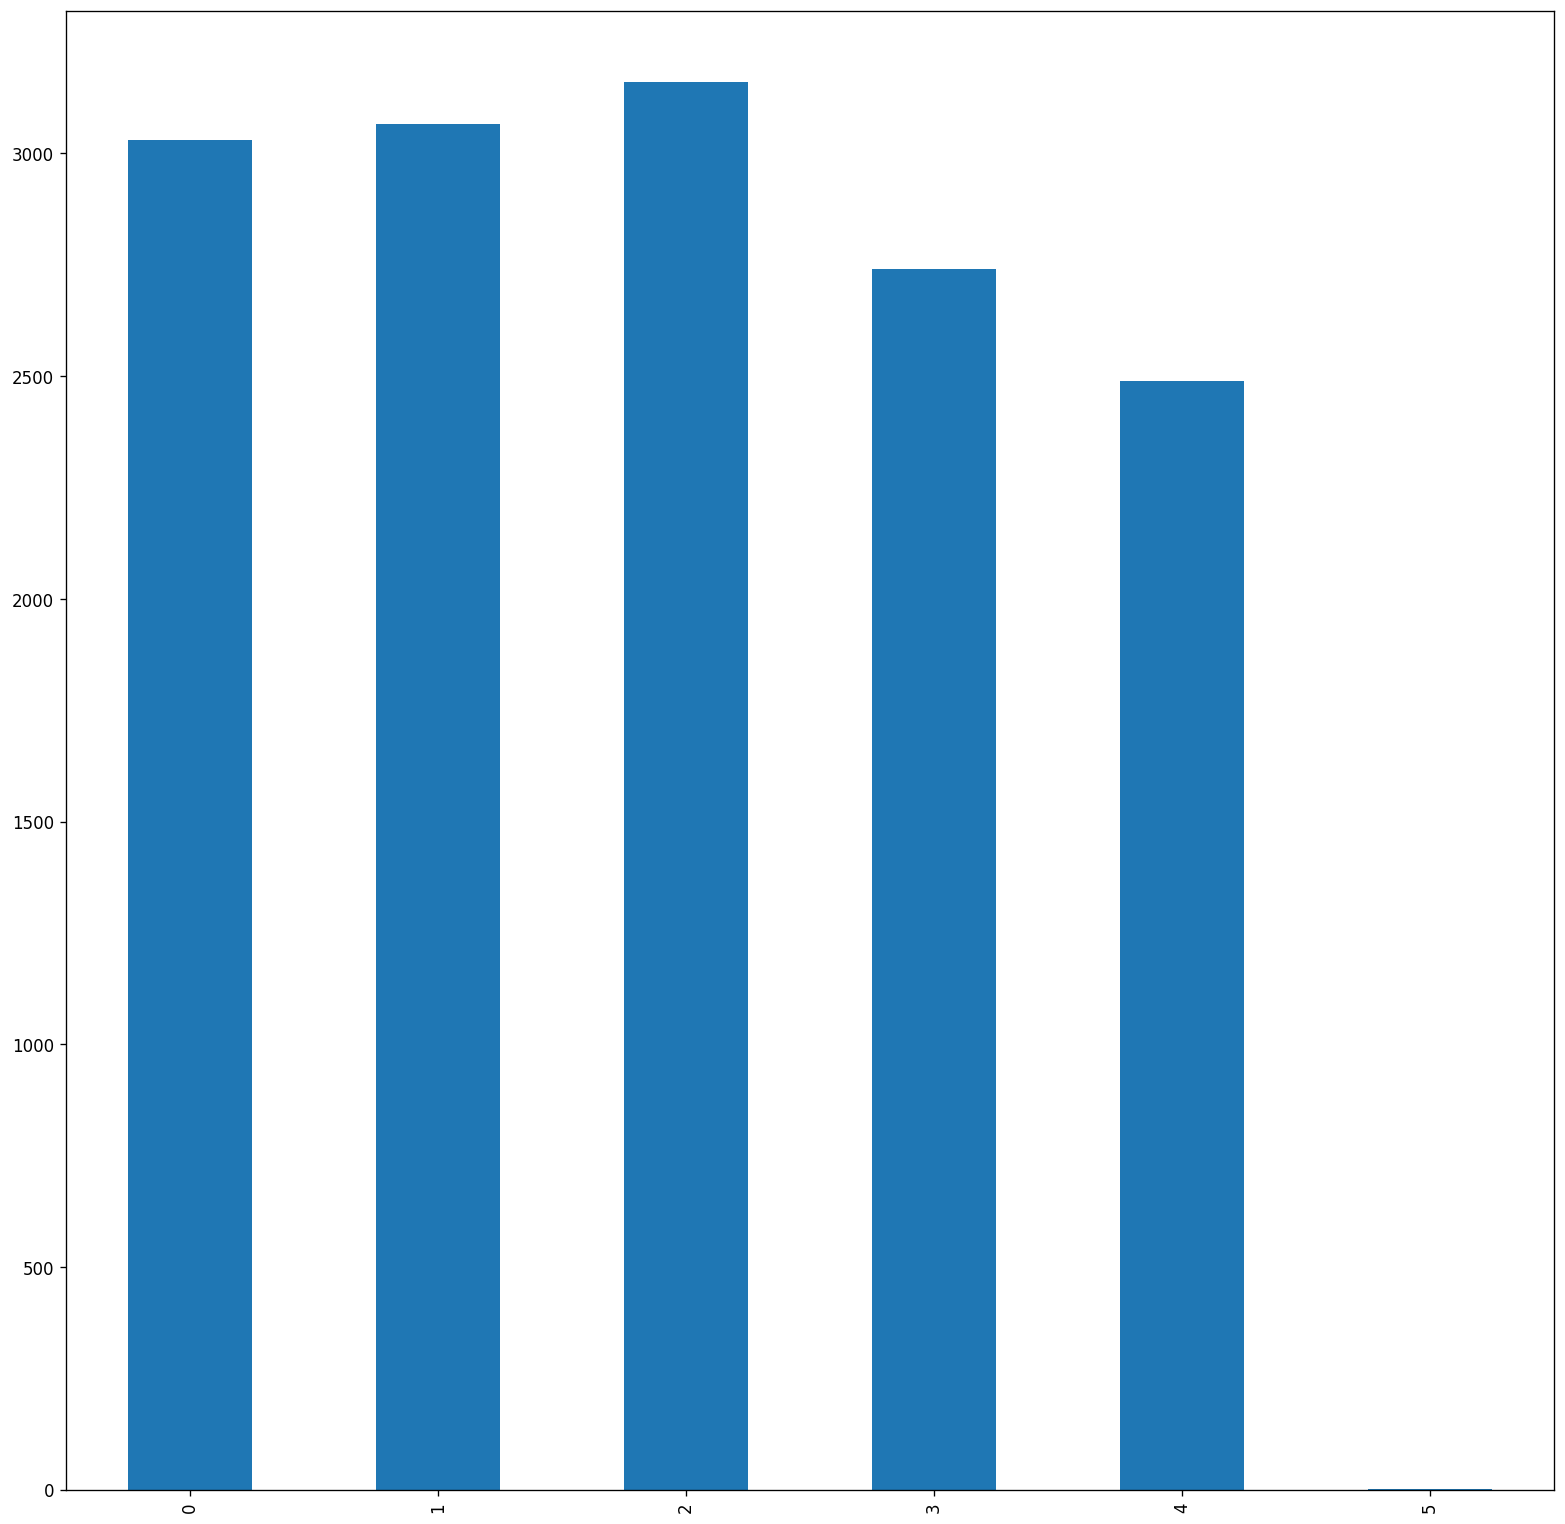

In [39]:
# 0 --> segunda
print(viagens_validas.dataInicio.dt.day_of_week.value_counts().sort_index())
viagens_validas.dataInicio.dt.day_of_week.value_counts().sort_index().plot(kind = 'bar' )


In [40]:
vol_semanal = viagens_validas.groupby(['day_of_week', pd.Grouper(freq='1D',key = 'dataInicio')]).agg({'sequence':'count'}).reset_index()
vol_semanal.drop(index = vol_semanal.loc[vol_semanal['day_of_week'] == 5].index,inplace = True, axis = 0)
vol_semanal.columns = ['day_of_week',	'Data',	'Volume']

vol_semanal

day_of_week       Data  Volume
0             0 2021-06-07     241
1             0 2021-06-14     287
2             0 2021-06-21     114
3             0 2021-06-28     128
4             0 2021-07-05     256
..          ...        ...     ...
58            4 2021-07-30     246
59            4 2021-08-06     112
60            4 2021-08-13     153
61            4 2021-08-20     281
62            4 2021-08-27     279

[63 rows x 3 columns]

In [41]:
segundas =  vol_semanal.loc[vol_semanal['day_of_week'] == 0]
tercas =    vol_semanal.loc[vol_semanal['day_of_week'] == 1]
quartas =   vol_semanal.loc[vol_semanal['day_of_week'] == 2]
quintas =   vol_semanal.loc[vol_semanal['day_of_week'] == 3]
sextas =    vol_semanal.loc[vol_semanal['day_of_week'] == 4]

In [42]:
segundas

day_of_week       Data  Volume
0             0 2021-06-07     241
1             0 2021-06-14     287
2             0 2021-06-21     114
3             0 2021-06-28     128
4             0 2021-07-05     256
5             0 2021-07-12     278
6             0 2021-07-19     284
7             0 2021-07-26     267
8             0 2021-08-02     288
9             0 2021-08-09     126
10            0 2021-08-16     222
11            0 2021-08-23     318
12            0 2021-08-30     221

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_21359/2582163071.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0][0].set_xticklabels(labels = segundas   .Data , rotation = 60)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_21359/2582163071.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0][1].set_xticklabels(labels = tercas     .Data , rotation = 60)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_21359/2582163071.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1][0].set_xticklabels(labels = quartas    .Data , rotation = 60)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_21359/2582163071.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1][1].set_xticklabels(labels = quintas    .Data , rotation = 60)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_21359/2582163071.py:25: UserW

[Text(18779.0, 0, '2021-06-11 00:00:00'),
 Text(18793.0, 0, '2021-06-18 00:00:00'),
 Text(18809.0, 0, '2021-06-25 00:00:00'),
 Text(18823.0, 0, '2021-07-02 00:00:00'),
 Text(18840.0, 0, '2021-07-16 00:00:00'),
 Text(18854.0, 0, '2021-07-23 00:00:00'),
 Text(18871.0, 0, '2021-07-30 00:00:00')]

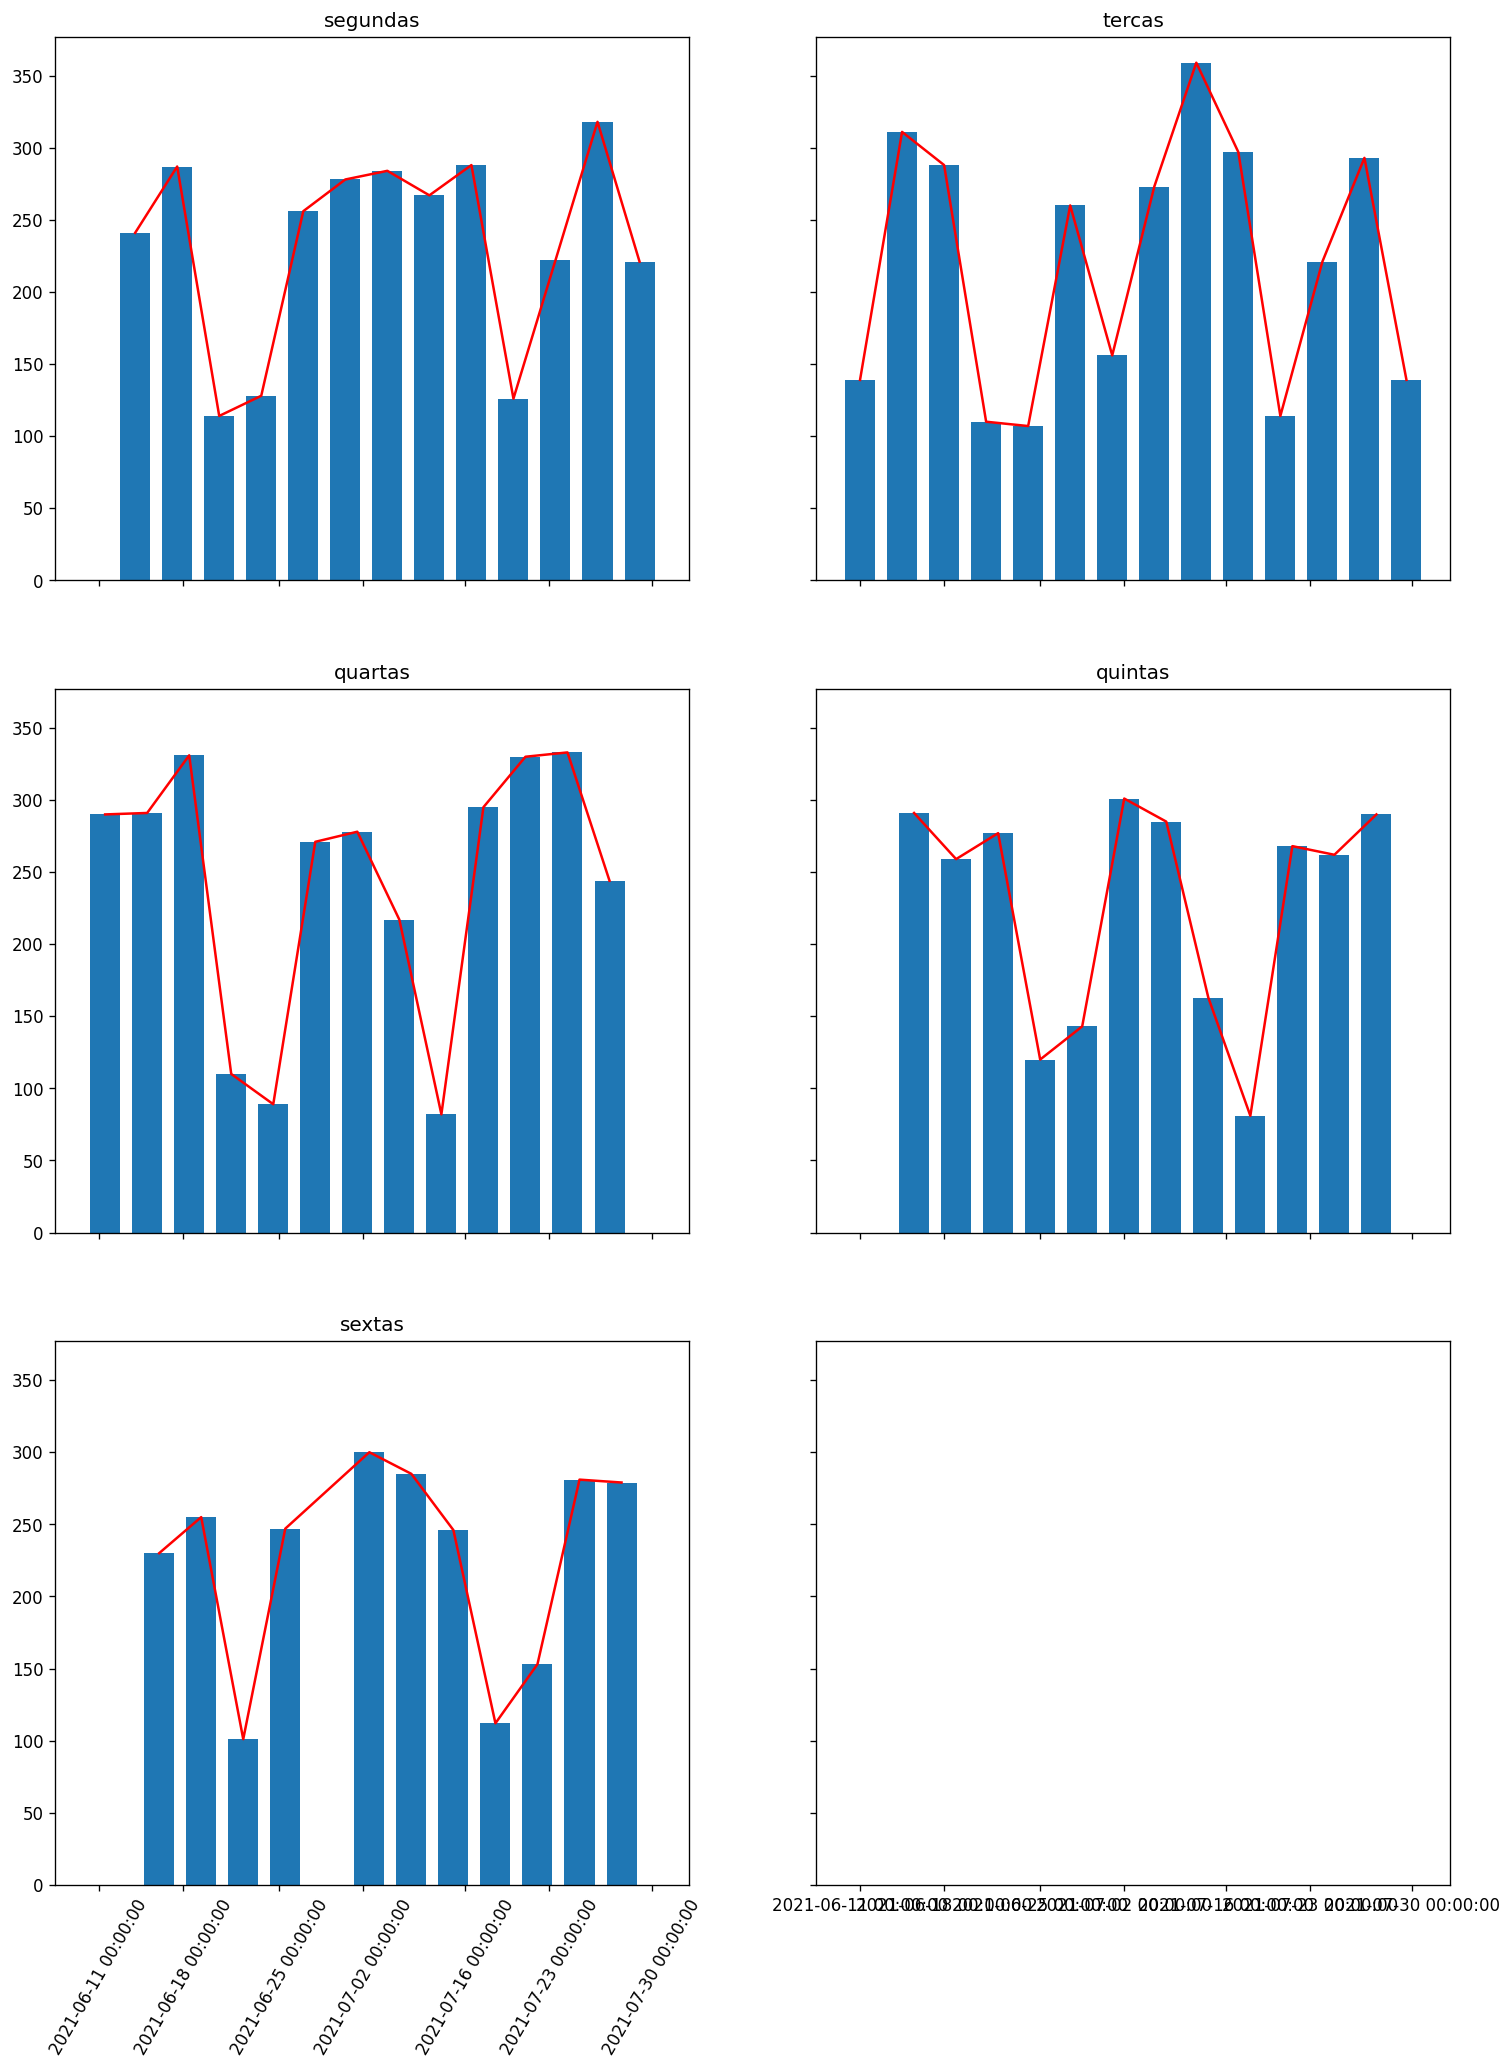

In [43]:
fig, ax = plt.subplots(3,2,figsize=(15,20), sharex= True, sharey = True)

ax[0][0].bar(segundas   .Data, segundas   .Volume, width = 5)
ax[0][1].bar(tercas     .Data, tercas     .Volume, width = 5)
ax[1][0].bar(quartas    .Data, quartas    .Volume, width = 5)
ax[1][1].bar(quintas    .Data, quintas    .Volume, width = 5)
ax[2][0].bar(sextas     .Data, sextas     .Volume, width = 5)

ax[0][0].plot(segundas   .Data, segundas   .Volume, color = 'red')
ax[0][1].plot(tercas     .Data, tercas     .Volume, color = 'red')
ax[1][0].plot(quartas    .Data, quartas    .Volume, color = 'red')
ax[1][1].plot(quintas    .Data, quintas    .Volume, color = 'red')
ax[2][0].plot(sextas     .Data, sextas     .Volume, color = 'red')

ax[0][0].set_title('segundas')
ax[0][1].set_title('tercas')
ax[1][0].set_title('quartas')
ax[1][1].set_title('quintas')
ax[2][0].set_title('sextas')

ax[0][0].set_xticklabels(labels = segundas   .Data , rotation = 60)
ax[0][1].set_xticklabels(labels = tercas     .Data , rotation = 60)
ax[1][0].set_xticklabels(labels = quartas    .Data , rotation = 60)
ax[1][1].set_xticklabels(labels = quintas    .Data , rotation = 60)
ax[2][0].set_xticklabels(labels = sextas     .Data , rotation = 60)

# segundas.Data.dt.date.value_counts().sort_index().plot(kind = 'bar' ,figsize=(8,5))
# segundas.Data.dt.date.value_counts().sort_index().plot(kind = 'bar' ,figsize=(8,5))

## Media Movel

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_21359/4147941158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['media_movel3'] = df['Volume'].rolling(3).mean()
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_21359/4147941158.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels = df   .Data.dt.date , rotation = 60)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_21359/4147941158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

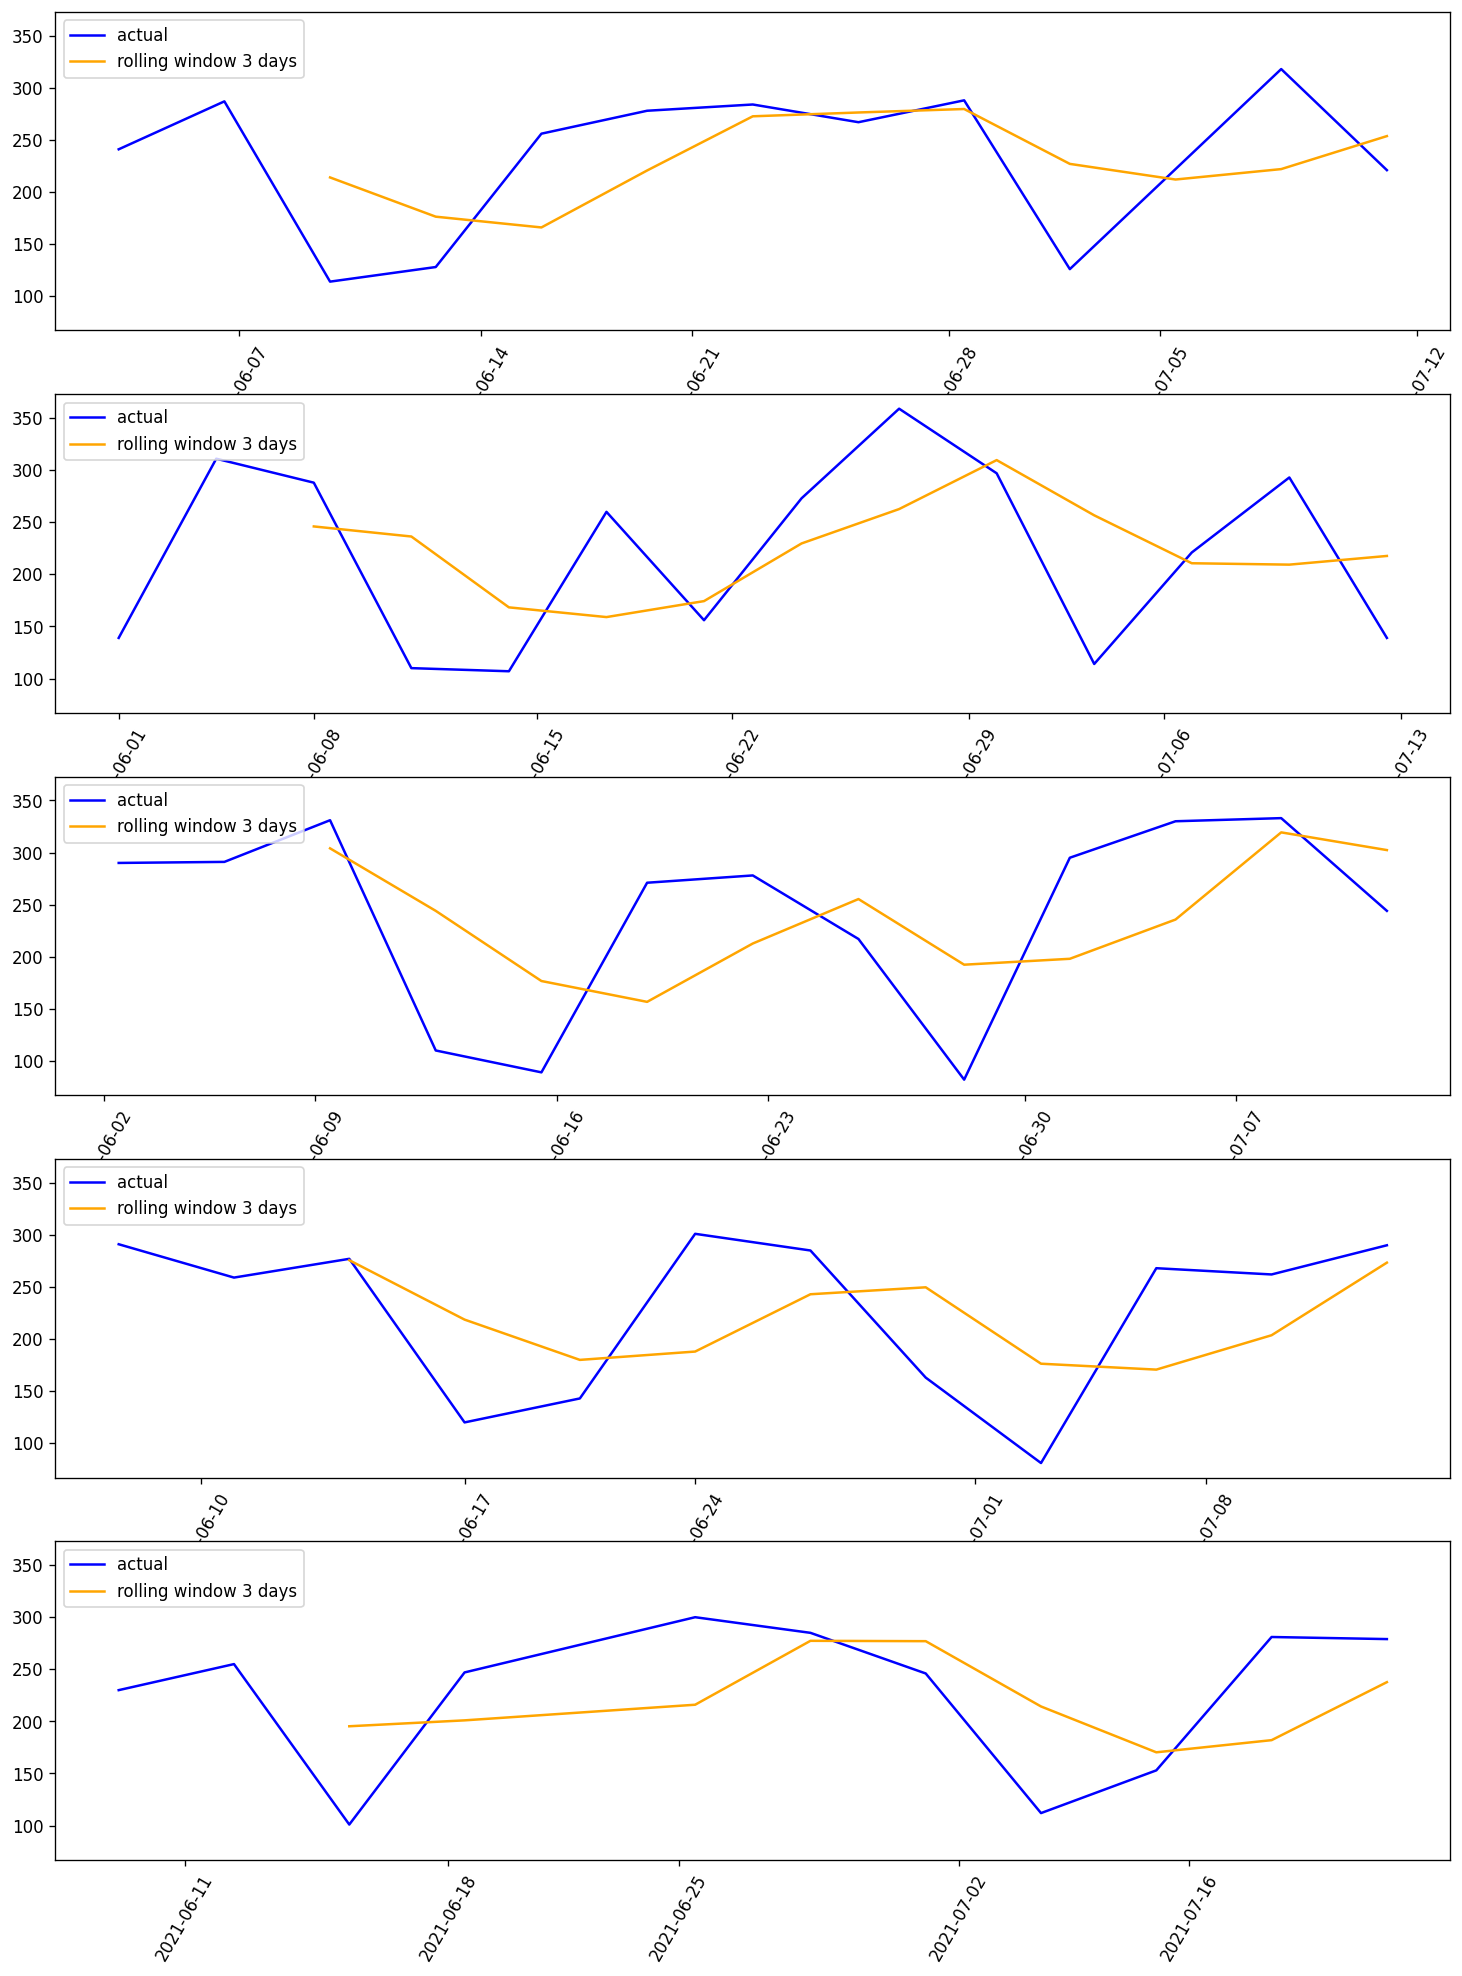

In [44]:

fig, ax = plt.subplots(nrows=5,figsize=(15,20), sharey = True)

for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

    df['media_movel3'] = df['Volume'].rolling(3).mean()
    ax[idx].plot(df   .Data.dt.date, df   .Volume, color = 'blue')
    ax[idx].plot(df   .Data.dt.date, df   .media_movel3, color = 'orange')
    ax[idx].legend(loc = 'upper left', labels = ['actual', 'rolling window 3 days'])
    ax[idx].set_xticklabels(labels = df   .Data.dt.date , rotation = 60)

    # ax[idx].set_title('')
plt.show()

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_21359/2876676256.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['media_movel5'] = df['Volume'].rolling(5).mean()
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_21359/2876676256.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels = df   .Data.dt.date , rotation = 60)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_21359/2876676256.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

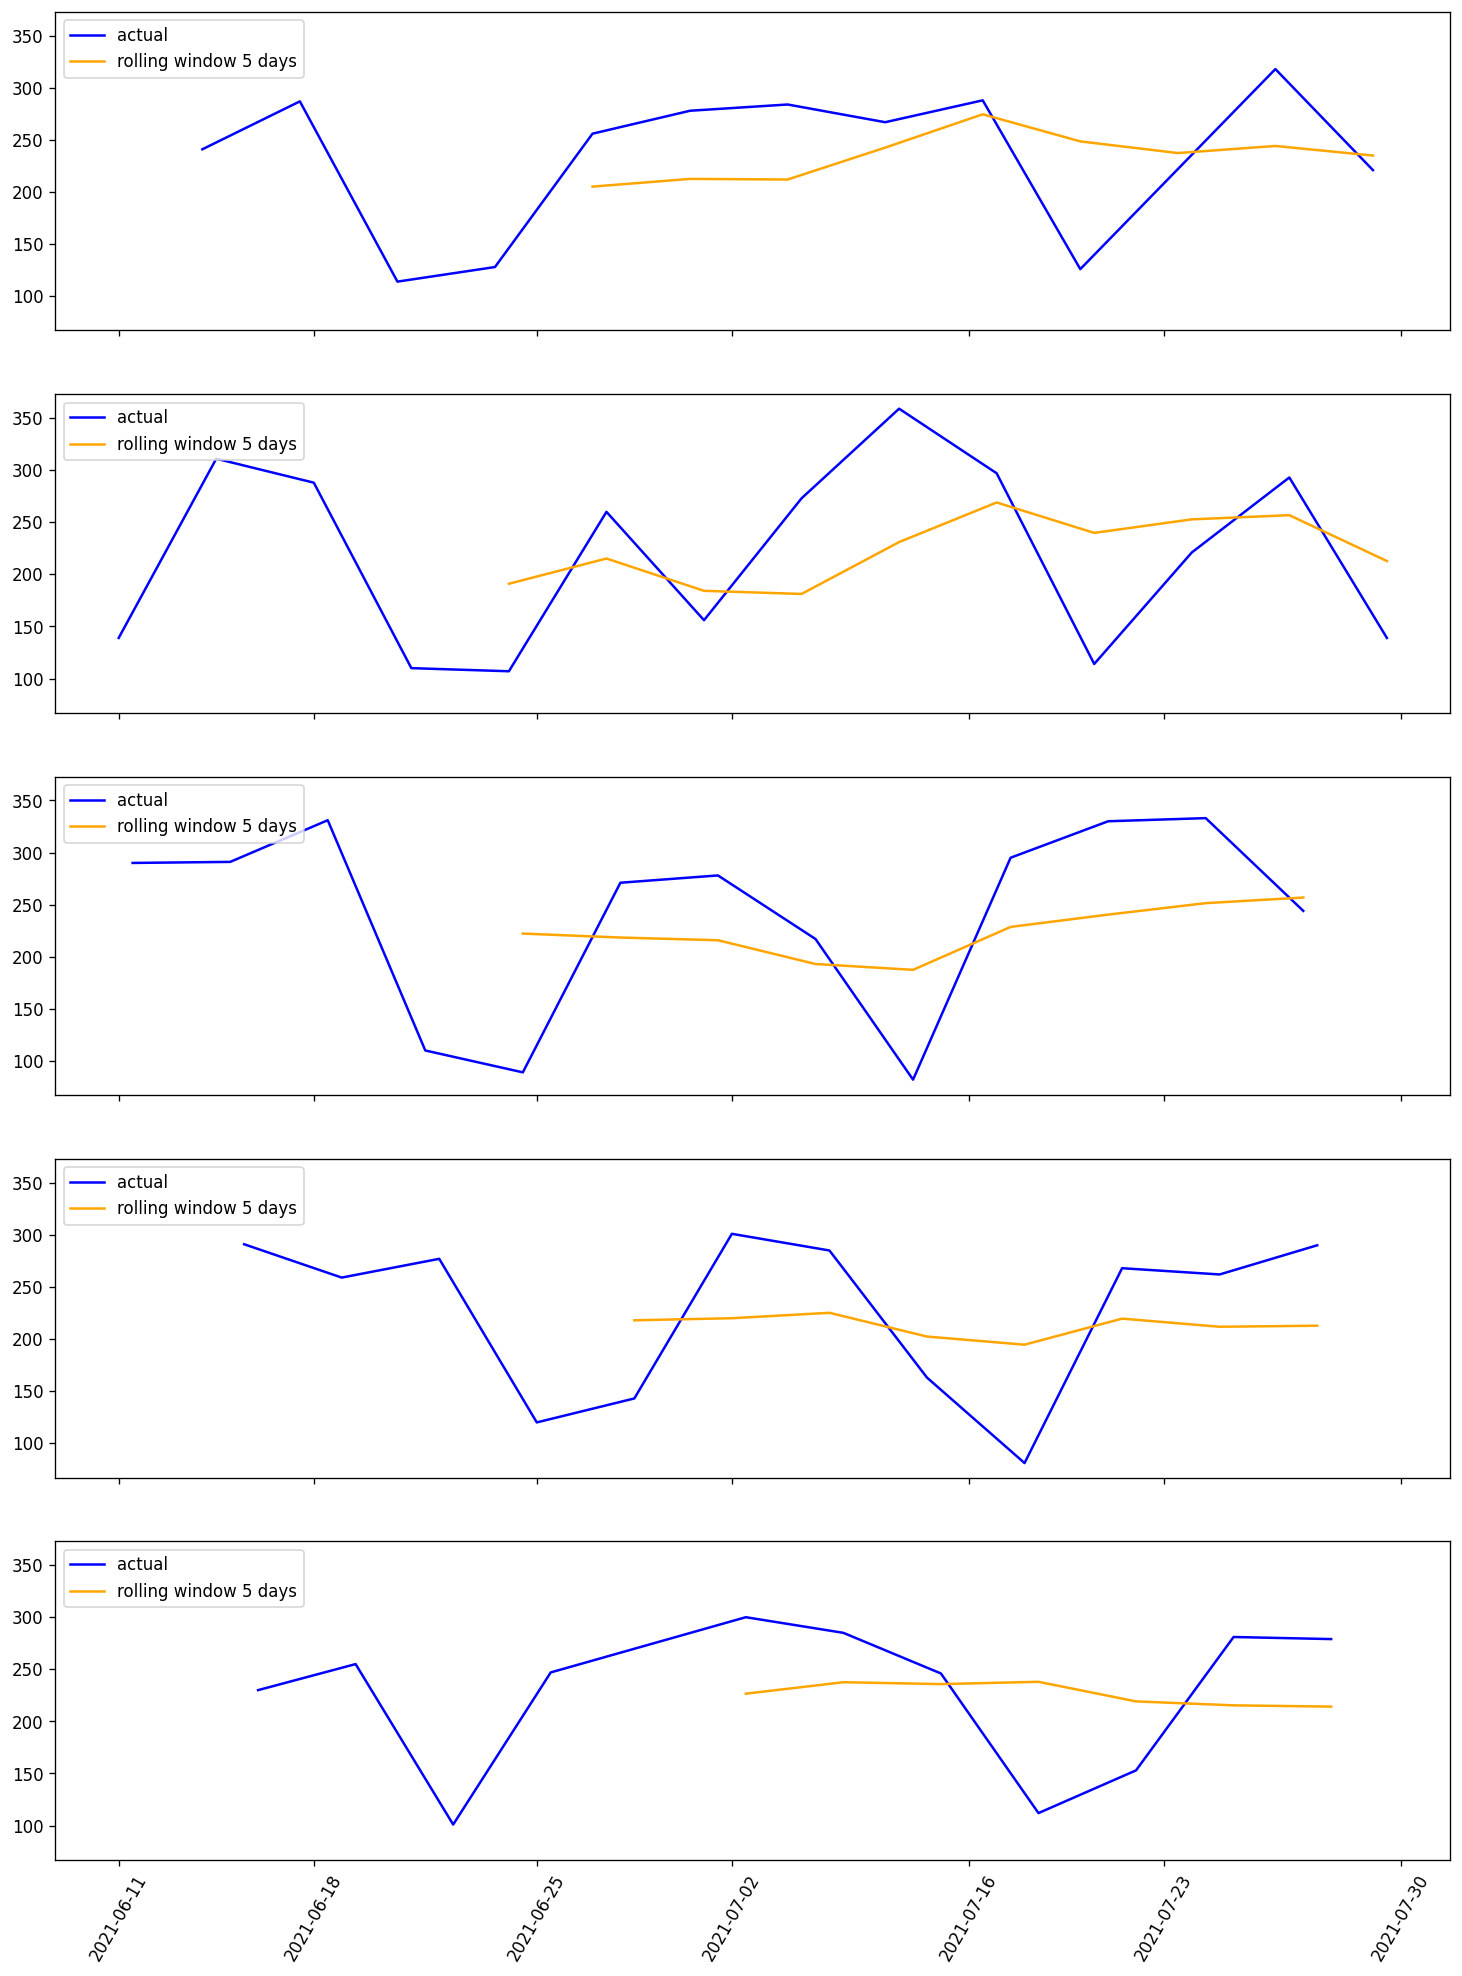

In [45]:
fig, ax = plt.subplots(nrows=5,figsize=(15,20), sharex= True, sharey = True)

for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

    df['media_movel5'] = df['Volume'].rolling(5).mean()
    ax[idx].plot(df   .Data.dt.date, df   .Volume, color = 'blue')
    ax[idx].plot(df   .Data.dt.date, df   .media_movel5, color = 'orange')
    ax[idx].legend(loc = 'upper left', labels = ['actual', 'rolling window 5 days'])
    ax[idx].set_xticklabels(labels = df   .Data.dt.date , rotation = 60)

    # ax[idx].set_title('')

plt.show()

In [46]:
sextas

day_of_week       Data  Volume  media_movel3  media_movel5
52            4 2021-06-11     230           NaN           NaN
53            4 2021-06-18     255           NaN           NaN
54            4 2021-06-25     101    195.333333           NaN
55            4 2021-07-02     247    201.000000           NaN
56            4 2021-07-16     300    216.000000         226.6
57            4 2021-07-23     285    277.333333         237.6
58            4 2021-07-30     246    277.000000         235.8
59            4 2021-08-06     112    214.333333         238.0
60            4 2021-08-13     153    170.333333         219.2
61            4 2021-08-20     281    182.000000         215.4
62            4 2021-08-27     279    237.666667         214.2

### calculo do erro

In [47]:
print('DF1 = Segundas')
print('DF2 = Tercas')
print('DF3 = Quartas')
print('DF4 = Quintas')
print('DF5 = Sextas')
print('******************************')

for idx, df in enumerate([segundas, tercas, df, quintas, sextas]):
    df['erro3'] = (df['media_movel3'] - df['Volume'])**2
    # print( 'erro3 quadratico soma do DF{}  '.format(idx+1),df['erro3'].sum())
    print( 'erro da MA(3) sqrt quadratico medio do DF{}  , RMSE'.format(idx+1),np.sqrt(df['erro3'].mean()))

    df['erro5'] = (df['media_movel5'] - df['Volume'])**2
    # print( 'erro5 quadratico soma do DF{}  '.format(idx+1),df['erro5'].sum())
    print( 'erro da MA(5) sqrt quadratico medio do DF{}  RMSE'.format(idx+1),np.sqrt(df['erro5'].mean()), end='\n')

    print('=====================================')

DF1 = Segundas
DF2 = Tercas
DF3 = Quartas
DF4 = Quintas
DF5 = Sextas
******************************
erro da MA(3) sqrt quadratico medio do DF1  , RMSE 63.669839679776835
erro da MA(5) sqrt quadratico medio do DF1  RMSE 61.216446591854165
erro da MA(3) sqrt quadratico medio do DF2  , RMSE 80.09912839956732
erro da MA(5) sqrt quadratico medio do DF2  RMSE 76.84222797394673
erro da MA(3) sqrt quadratico medio do DF3  , RMSE 67.80081575677355
erro da MA(5) sqrt quadratico medio do DF3  RMSE 72.2092198307905
erro da MA(3) sqrt quadratico medio do DF4  , RMSE 74.42632449461534
erro da MA(5) sqrt quadratico medio do DF4  RMSE 71.62558900281378
erro da MA(3) sqrt quadratico medio do DF5  , RMSE 67.80081575677355
erro da MA(5) sqrt quadratico medio do DF5  RMSE 72.2092198307905


/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_21359/588385930.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['erro3'] = (df['media_movel3'] - df['Volume'])**2
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_21359/588385930.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['erro5'] = (df['media_movel5'] - df['Volume'])**2
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_21359/588385930.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [48]:
vol_semanal#.to_excel('vol_semanal.xlsx')

day_of_week       Data  Volume
0             0 2021-06-07     241
1             0 2021-06-14     287
2             0 2021-06-21     114
3             0 2021-06-28     128
4             0 2021-07-05     256
..          ...        ...     ...
58            4 2021-07-30     246
59            4 2021-08-06     112
60            4 2021-08-13     153
61            4 2021-08-20     281
62            4 2021-08-27     279

[63 rows x 3 columns]

## Suavizacao Exponencial


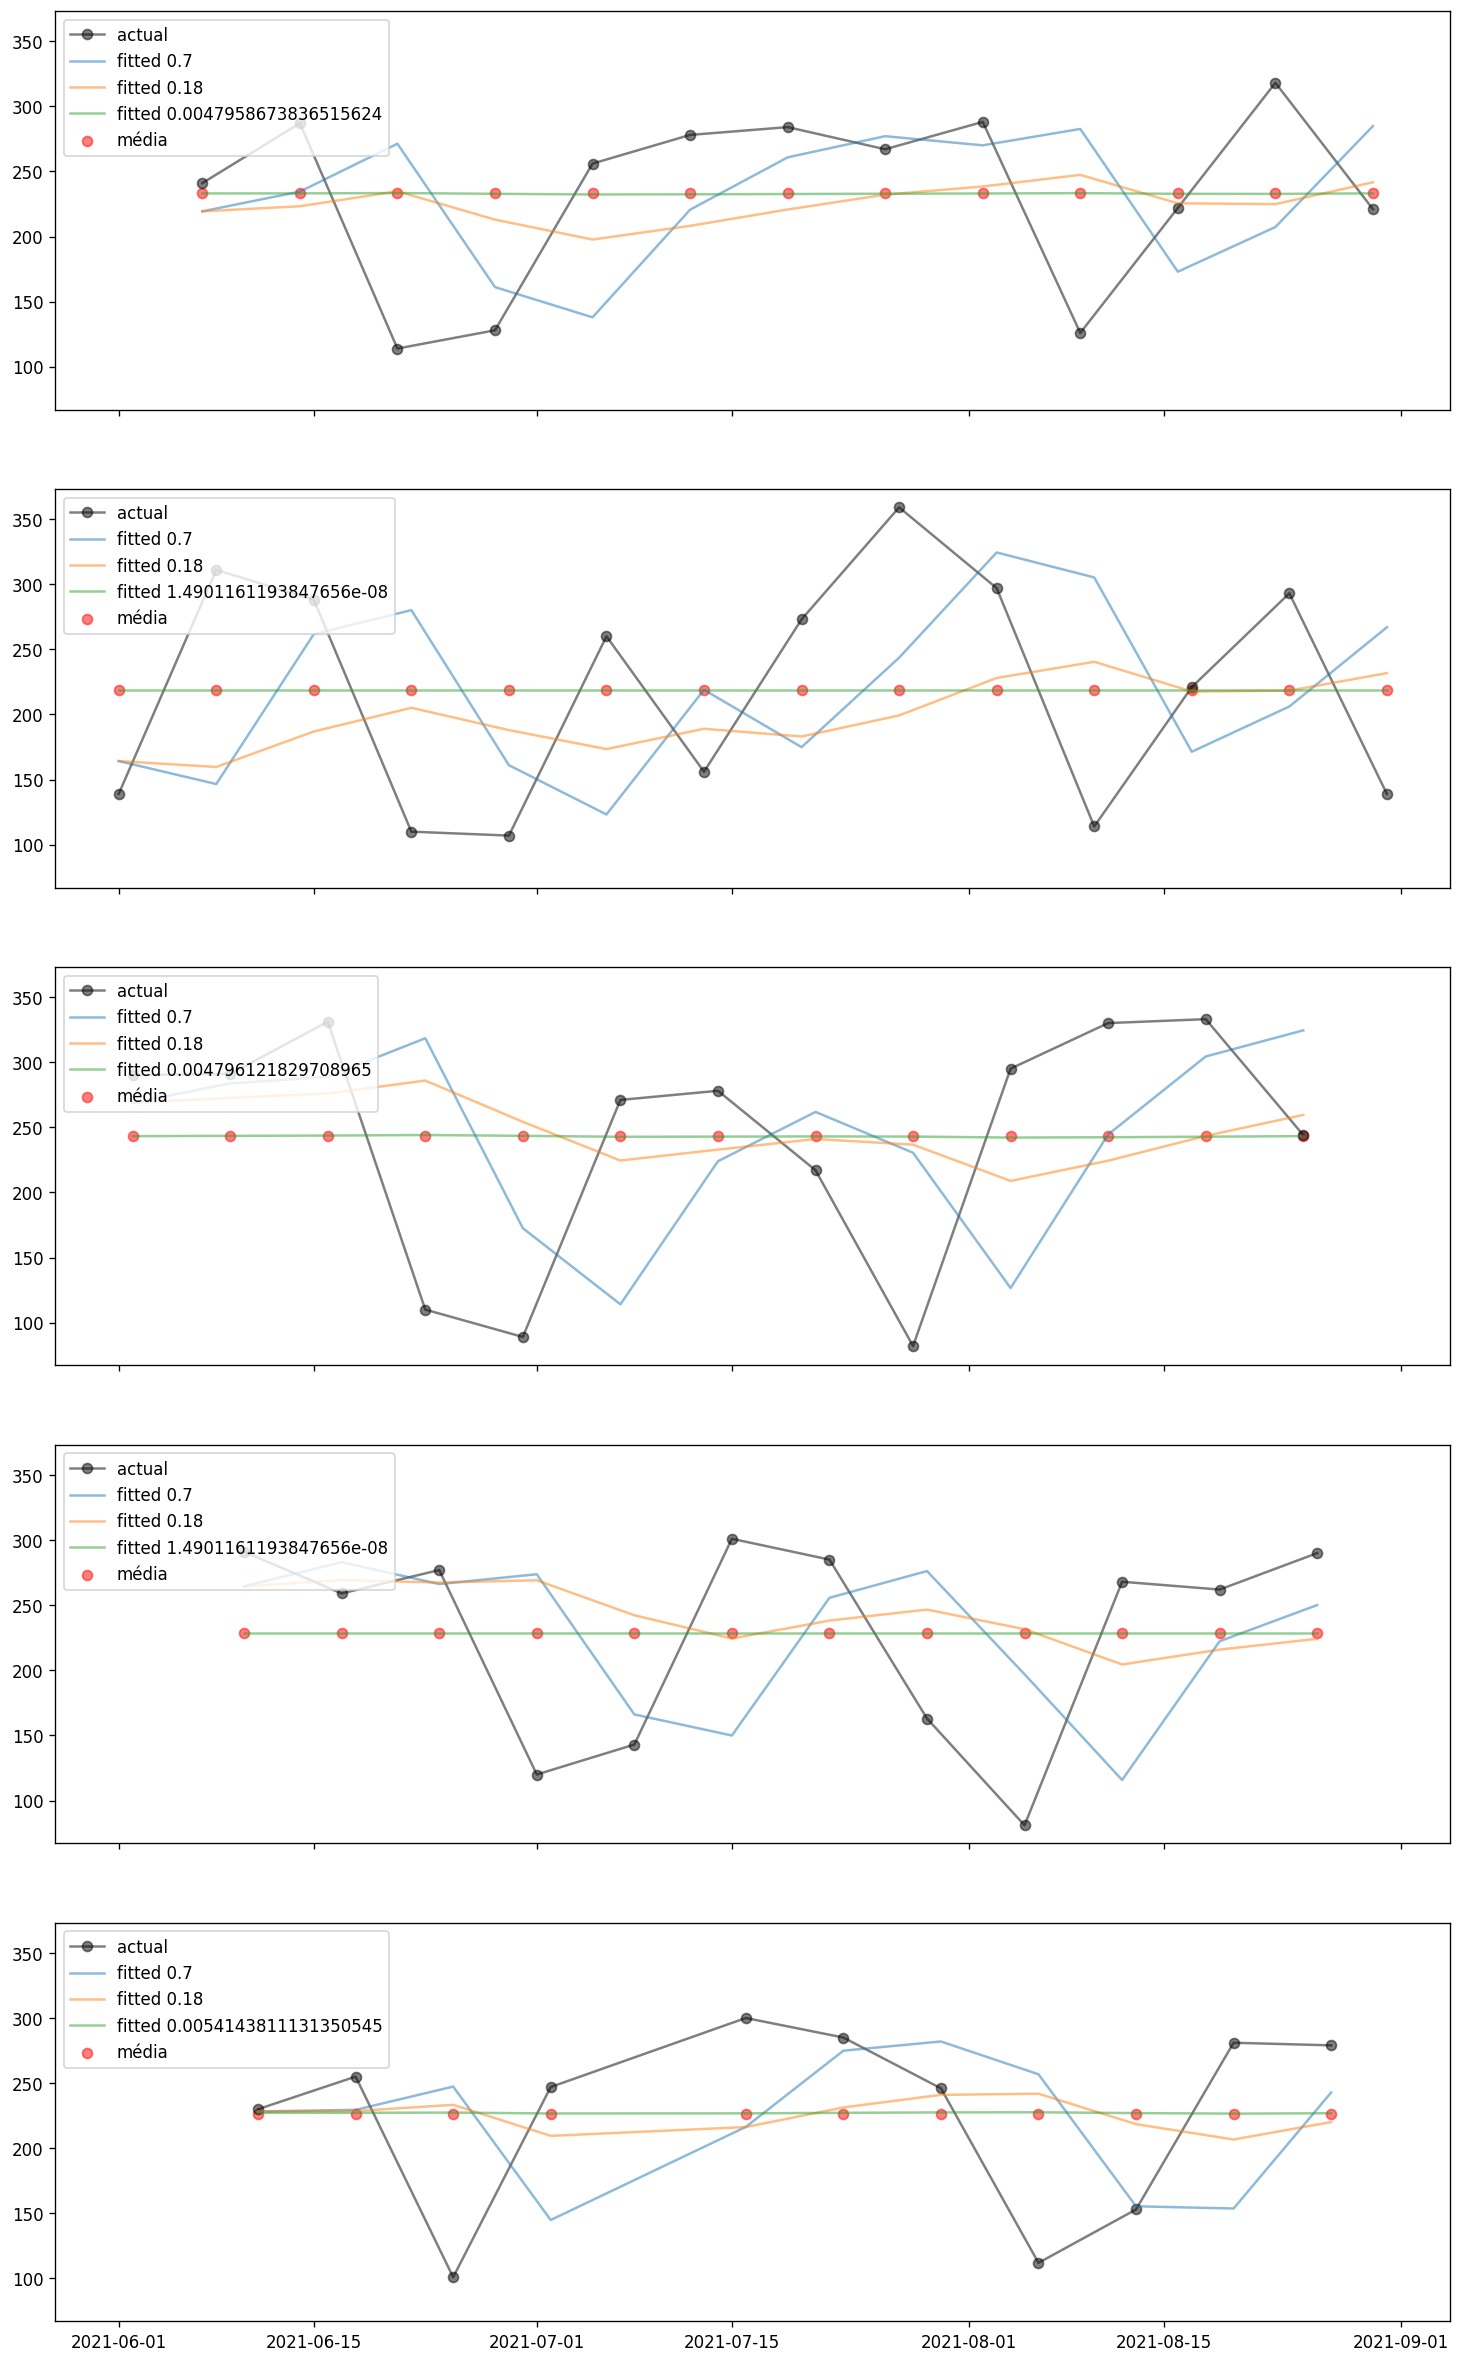

In [49]:
fig, ax = plt.subplots(nrows=5,figsize=(15,25), sharex= True, sharey = True)

params = [0.7,0.18 ]

## um grafico para cada dia da semana
for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

    ## para um grafico, adiciona a serie historica antes de tudo
    ax[idx].plot(df['Data'],df['Volume'], marker="o", color="black", alpha = 0.5)

    # vai gerar 3 modelos: 2 com parametros escolhidos, e um fitado para o melhor parametro
    for n_models in range(0,3): ###  0 1 2
        # gera modelo com parametros determinados
        if n_models != 2:
            fit1 = SimpleExpSmoothing(df['Volume'].values, initialization_method="heuristic").fit(smoothing_level=params[n_models], optimized=False)

        else:
            ## gera modelo com parametro alpha otimizado
            fit1 = SimpleExpSmoothing(df['Volume'].values, initialization_method="heuristic").fit()

        ax[idx].plot(df['Data'],fit1.fittedvalues,  alpha = 0.5)


    ################################# printa a media para comparar com as previsoes   #################################
    ax[idx].scatter(df['Data'],[df['Volume'].mean() for i in range(len(df['Volume']))], color='red', alpha = 0.5)


    ax[idx].legend(loc = 'upper left', labels = ['actual',
                                                 'fitted {}'.format(params[0]),
                                                 'fitted {}'.format(params[1]), 
                                                 'fitted {}'.format(fit1.model.params["smoothing_level"]),
                                                 'média'])

    # ax[idx].set_title('')

plt.show()

### como calcular o erro da suavizacao exponencial?

 - tem 3 modelagens pra cada dia da semana, seriam 15 calculos de erro
 - vamos primeiro validar se esses modelos fazem sentido pra algum das series temporais, depois avancar em so uma delas


In [50]:
# SimpleExpSmoothing(volumes_totais_diarios['Volume'].values, initialization_method="heuristic").score( np.ndarray(1))



## Metodo de Holt

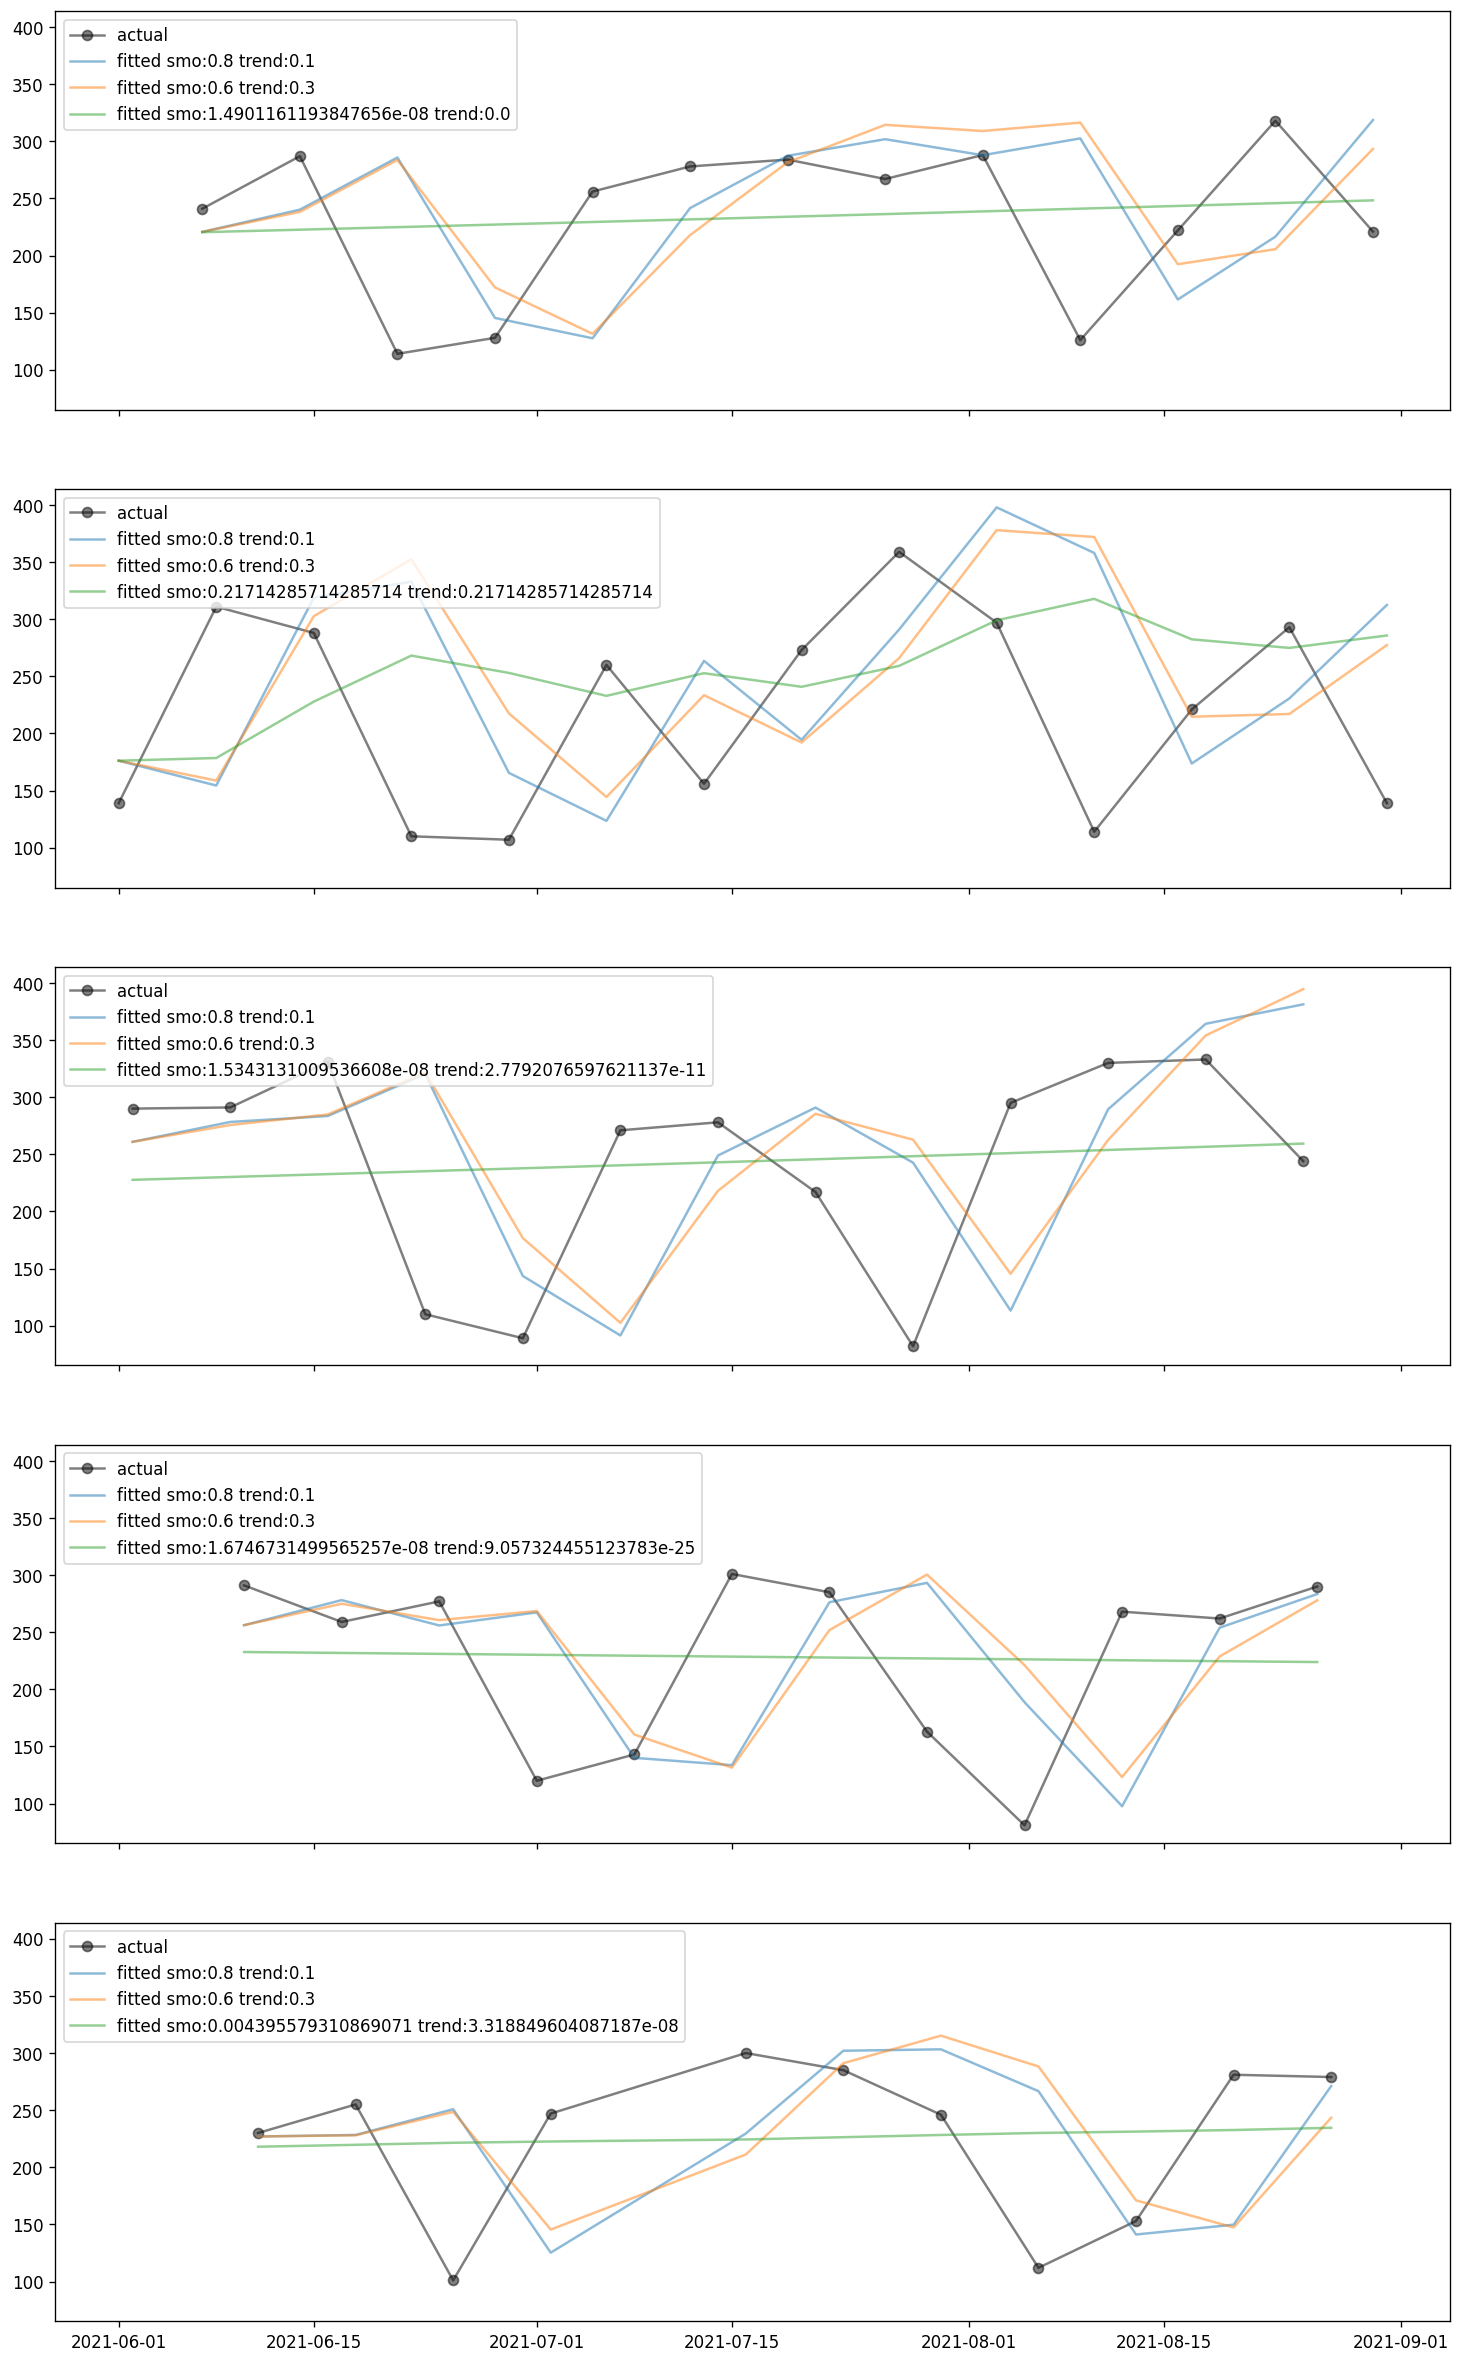

In [51]:
fig, ax = plt.subplots(nrows=5,figsize=(15,25), sharex= True, sharey = True)


params_alpha = [0.8,0.6]
params_beta = [0.1,0.3]

## um grafico para cada dia da semana
for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

    ## para um grafico, adiciona a serie historica antes de tudo
    ax[idx].plot(df['Data'],df['Volume'], marker="o", color="black", alpha = 0.5)

    # vai gerar 3 modelos: 2 com parametros escolhidos, e um fitado para o melhor parametro
    for n_models in range(0,3): ###  0 1 2
        # gera modelo com parametros determinados
        if n_models != 2:
            fit1 = Holt(df['Volume'].values, exponential=True,initialization_method="heuristic").fit(smoothing_level=params_alpha[n_models],
                                                                                                    smoothing_trend=params_beta[n_models], optimized=False)

        else:
            ## gera modelo com parametro alpha otimizado
            fit1 = Holt(df['Volume'].values, exponential=True,initialization_method="heuristic").fit(optimized=True)

        ax[idx].plot(df['Data'],fit1.fittedvalues,  alpha = 0.5)


    ################################# printa a media para comparar com as previsoes   #################################
    # ax[idx].scatter(df['Data'],[df['Volume'].mean() for i in range(len(df['Volume']))], color='red', alpha = 0.5)


    ax[idx].legend(loc = 'upper left', labels = ['actual',
                                                 'fitted smo:{} trend:{}'.format(params_alpha[0], params_beta[0]),
                                                 'fitted smo:{} trend:{}'.format(params_alpha[1], params_beta[1]), 
                                                 'fitted smo:{} trend:{}'.format(fit1.model.params["smoothing_level"],fit1.model.params["smoothing_trend"]),
                                                 'média'])

    # ax[idx].set_title('')

plt.show()

#### como calcular o erro do metodo de holt?

O metodo de holts tem 2 hyperparametros serem ajustados, mas tambem uma serie de metodos de calculo que variam os resultados
 - exponential=True
 - damped_trend=True
 - entre outros 

Calculo do erro

 - tem 3 modelagens pra cada dia da semana, seriam 15 calculos de erro
 - vamos primeiro validar se esses modelos fazem sentido pra algum das series temporais, depois avancar em so uma delas


# Volume de Viagens por par OD



## Organizacao dos dados - ODs diarias

In [52]:
agrupamento = viagens_validas.groupby([pd.Grouper(freq='1D',key = 'dataInicio'),'NEW_PontoInicial','NEW_PontoFinal']).agg({'sequence':'count'}).reset_index()
agrupamento.columns = ['Data',	'PontoInicial',	'PontoFinal',	'Volume']
agrupamento


Data  PontoInicial  PontoFinal  Volume
0    2021-06-01             1           6       2
1    2021-06-01             1          10       2
2    2021-06-01             1          17       3
3    2021-06-01             1          20       3
4    2021-06-01             1          23       4
...         ...           ...         ...     ...
5110 2021-08-31            32          31       1
5111 2021-08-31            33          13       1
5112 2021-08-31            33          15       1
5113 2021-08-31            33          17       3
5114 2021-08-31            33          33       3

[5115 rows x 4 columns]

- muitas ODs nao tem viagens de todos pra todos os 18 pontos (ou seja, nem tod dia tem viagem de 18 x 18)

- o codigo abaixo organiza essa logica

In [53]:
data__ = datetime(2021,6,1)

for day in range(5):

    print(data__)
    print(agrupamento.loc[agrupamento['Data'] == data__].pivot(index= 'PontoInicial', columns='PontoFinal', values='Volume').fillna(0).shape)

    data__ = data__ + timedelta(days=1)

2021-06-01 00:00:00
(16, 16)
2021-06-02 00:00:00
(17, 17)
2021-06-03 00:00:00
(0, 0)
2021-06-04 00:00:00
(0, 0)
2021-06-05 00:00:00
(0, 0)


In [54]:

##########      GERA ODs DE TODOS OS DIAS DA ANALISE    #####################################

start_date, end_date, delta = datetime(2021, 6, 1) , datetime(2021, 8, 31) , timedelta(days=1)

ODs_diarios = []
# Gerando as ODs de cada dia
while (start_date <= end_date):

    ODs_diarios.append(agrupamento.loc[agrupamento['Data'] == start_date].pivot(index= 'PontoInicial', columns='PontoFinal', values='Volume').fillna(0))
    # print(start_date, end="\n")
    start_date += delta

# print('ODS antes ---------------------------------------------------------------------------------------------------')
# display(ODs_diarios[1])

########        CRIA UM DF_AUX COM TODAS AS LINHAS E COLUNAS E POPULA COM OS DADOS DA ODS  #####################################


escolhe_18 = [1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33]

for df in range(len(ODs_diarios)):

    df_aux = pd.DataFrame(columns = escolhe_18, index=escolhe_18)

    for col in escolhe_18:

        try:
            df_aux.loc[:,col] = ODs_diarios[df][col]

        except:
            pass

    ODs_diarios[df] = df_aux.fillna(0).copy()

# print('ODS dps ---------------------------------------------------------------------------------------------------')
# display(ODs_diarios[1])



In [55]:
## aqui garante que todos os DF tem 18x18

data__ = datetime(2021,6,1)

for day in range(5):

    print(data__)

    display(ODs_diarios[day].shape)

    # if ODs_diarios[day].shape != (18,18):
    #     print(data__)

    #     display(ODs_diarios[day].shape)

    data__ = data__ + timedelta(days=1)

2021-06-01 00:00:00


(18, 18)

2021-06-02 00:00:00


(18, 18)

2021-06-03 00:00:00


(18, 18)

2021-06-04 00:00:00


(18, 18)

2021-06-05 00:00:00


(18, 18)

In [56]:
escolhe_18 = [1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33]

TODAS_324_ODS = []

for col in escolhe_18:
    for row in escolhe_18:

        aux = []

        for i in range(92):

            aux.append(ODs_diarios[i][col][row])
        TODAS_324_ODS.append(aux)


In [57]:
len(TODAS_324_ODS)

324

printando a serie historica de pares ODs aleatorios so pra ter ums nocao

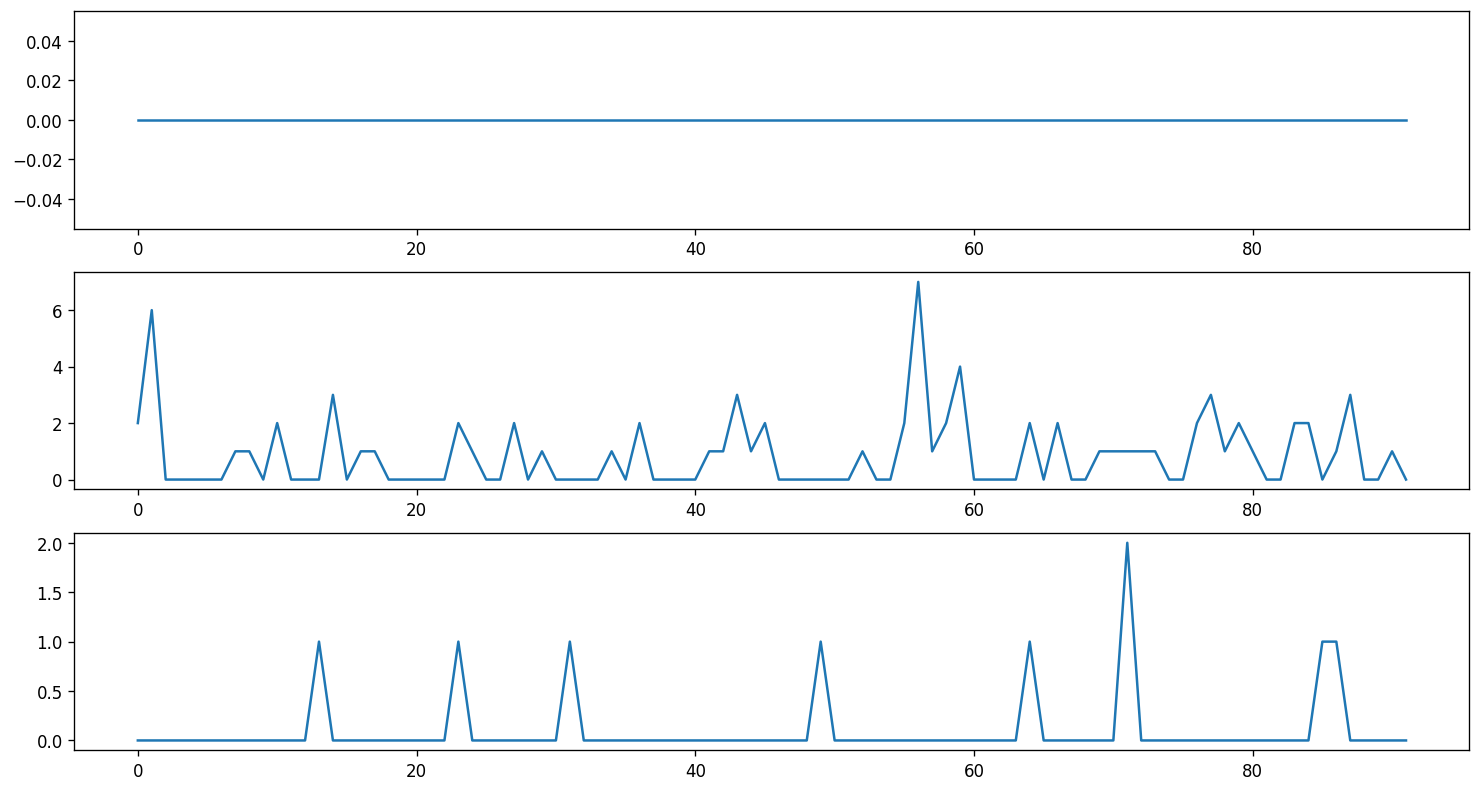

In [58]:
amostra = random.sample(TODAS_324_ODS,3)

fig, ax = plt.subplots(nrows=3, figsize = (15,8))

for aaa in range(len(amostra)):
    ax[aaa].plot(amostra[aaa])

Isso aqui significa quais dias tem mais de 324 viagens atraves das entradas da OD 

Ou seja, como se tivesse pelo menos uma viagem para cada OD, de fato sao pouquissimos dias, so 4

In [59]:

for i in range(92):

    if ODs_diarios[i].sum().sum() >=324:

        print(datetime(2021,6,1) + timedelta(days = i), '==================================================================')
        display(ODs_diarios[i])

2021-06-16 00:00:00 ==================================================================


1     5    6    8    9     10   13   15    17   18   20   21   22   23  \
1   0.0   2.0  2.0  0.0  1.0   3.0  0.0  0.0   4.0  0.0  5.0  2.0  1.0  7.0   
5   0.0   3.0  0.0  0.0  0.0   1.0  0.0  2.0   0.0  0.0  0.0  2.0  7.0  0.0   
6   0.0   0.0  0.0  0.0  3.0   1.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  1.0   
8   4.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  2.0  0.0  1.0  0.0   
9   0.0   1.0  3.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  1.0  0.0  0.0   
10  1.0   4.0  1.0  0.0  1.0   0.0  6.0  1.0  15.0  0.0  0.0  0.0  0.0  0.0   
13  3.0   0.0  0.0  3.0  0.0   2.0  0.0  0.0   4.0  0.0  0.0  0.0  0.0  0.0   
15  0.0   1.0  2.0  0.0  1.0   1.0  3.0  0.0   0.0  0.0  0.0  0.0  1.0  0.0   
17  3.0   6.0  0.0  2.0  0.0  10.0  9.0  0.0   7.0  0.0  0.0  1.0  0.0  0.0   
18  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
20  3.0   0.0  0.0  0.0  2.0   3.0  0.0  0.0   3.0  0.0  0.0  0.0  0.0  0.0   
21  2.0  30.0  0.0  0.0  0.0   0.0  0.0  1.0   0.0  0.0  0.0  3.0  0.0  0.0   
22  0.0   2.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  1.0  0.0  0.0  0.0  0.0   
23  2.0   2.0  1.0  0.0  2.0   0.0  0.0  1.0   0.0  0.0  0.0  0.0  0.0  0.0   
26  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
31  0.0   2.0  0.0  0.0  0.0   1.0  0.0  0.0   0.0  0.0  0.0  0.0  1.0  0.0   
32  3.0   0.0  2.0  4.0  0.0   1.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0   
33  0.0   0.0  0.0  0.0  0.0   5.0  8.0  0.0   2.0  0.0  0.0  0.0  0.0  0.0   

    26   31    32    33  
1    0  0.0   2.0   0.0  
5    0  2.0   0.0   0.0  
6    0  2.0   3.0   1.0  
8    0  0.0   0.0   0.0  
9    0  3.0   1.0   0.0  
10   0  4.0  12.0   7.0  
13   0  1.0   3.0   7.0  
15   0  2.0   0.0   0.0  
17   0  1.0   4.0   7.0  
18   0  0.0   0.0   1.0  
20   0  0.0   0.0   0.0  
21   0  0.0   0.0   0.0  
22   0  0.0   0.0   0.0  
23   0  0.0   0.0   0.0  
26   0  0.0   0.0   0.0  
31   0  0.0   0.0   0.0  
32   0  0.0   0.0   0.0  
33   0  1.0   2.0  29.0

2021-07-27 00:00:00 ==================================================================


1     5    6    8    9     10   13   15   17   18   20   21    22   23  \
1   0.0   3.0  2.0  0.0  4.0   7.0  0.0  1.0  3.0  1.0  3.0  2.0   0.0  5.0   
5   0.0   4.0  1.0  0.0  1.0   3.0  0.0  0.0  0.0  1.0  0.0  3.0  12.0  1.0   
6   0.0   7.0  0.0  0.0  2.0   0.0  1.0  0.0  2.0  0.0  0.0  0.0   0.0  0.0   
8   1.0   1.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  1.0   
9   0.0   1.0  1.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  1.0   1.0  0.0   
10  1.0   4.0  2.0  1.0  1.0   1.0  8.0  0.0  9.0  2.0  0.0  0.0   0.0  1.0   
13  0.0   0.0  0.0  0.0  0.0   4.0  2.0  0.0  6.0  0.0  0.0  0.0   0.0  0.0   
15  1.0   1.0  0.0  0.0  1.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   
17  1.0   2.0  0.0  1.0  0.0  20.0  6.0  0.0  2.0  0.0  0.0  0.0   0.0  1.0   
18  0.0   0.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   
20  3.0   0.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  7.0   
21  2.0  25.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  2.0   0.0  0.0   
22  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  1.0  0.0  0.0   4.0  0.0   
23  4.0   9.0  1.0  0.0  0.0   0.0  0.0  1.0  0.0  0.0  1.0  0.0   1.0  2.0   
26  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   
31  1.0   1.0  0.0  0.0  0.0   2.0  0.0  0.0  0.0  0.0  0.0  0.0   2.0  0.0   
32  5.0   1.0  2.0  1.0  0.0   1.0  0.0  0.0  1.0  0.0  2.0  0.0   0.0  2.0   
33  0.0   1.0  0.0  0.0  1.0   4.0  5.0  1.0  3.0  0.0  0.0  0.0   0.0  0.0   

    26   31   32    33  
1    0  2.0  1.0   0.0  
5    0  4.0  0.0   0.0  
6    0  5.0  0.0   1.0  
8    0  0.0  0.0   0.0  
9    0  4.0  0.0   2.0  
10   0  1.0  9.0  12.0  
13   0  1.0  2.0   6.0  
15   0  2.0  0.0   0.0  
17   0  1.0  2.0   7.0  
18   0  0.0  0.0   0.0  
20   0  0.0  1.0   0.0  
21   0  0.0  0.0   0.0  
22   0  0.0  0.0   0.0  
23   0  1.0  0.0   0.0  
26   0  0.0  0.0   0.0  
31   0  0.0  0.0   0.0  
32   0  1.0  3.0   0.0  
33   0  1.0  0.0  33.0

2021-08-11 00:00:00 ==================================================================


1     5    6    8    9     10   13   15    17   18   20   21    22    23  \
1   0.0   3.0  1.0  0.0  0.0   6.0  1.0  3.0   3.0  1.0  3.0  0.0   1.0  10.0   
5   0.0   2.0  0.0  0.0  0.0   1.0  0.0  1.0   0.0  0.0  0.0  3.0  12.0   0.0   
6   0.0   3.0  0.0  0.0  1.0   3.0  0.0  0.0   1.0  0.0  0.0  0.0   0.0   0.0   
8   1.0   1.0  2.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0   
9   0.0   2.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0   
10  4.0   6.0  2.0  0.0  1.0   0.0  7.0  0.0  10.0  2.0  1.0  1.0   0.0   3.0   
13  0.0   1.0  0.0  1.0  0.0   6.0  1.0  0.0   5.0  0.0  0.0  0.0   0.0   0.0   
15  0.0   0.0  0.0  0.0  1.0   1.0  0.0  0.0   1.0  0.0  0.0  0.0   0.0   0.0   
17  0.0   1.0  1.0  0.0  0.0  15.0  8.0  0.0   2.0  0.0  0.0  1.0   0.0   0.0   
18  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0   
20  2.0   0.0  0.0  0.0  0.0   2.0  0.0  0.0   1.0  0.0  0.0  0.0   0.0   1.0   
21  0.0  35.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0   
22  0.0   0.0  0.0  0.0  0.0   1.0  0.0  0.0   0.0  2.0  0.0  0.0   1.0   0.0   
23  1.0   3.0  1.0  0.0  0.0   1.0  0.0  0.0   1.0  0.0  1.0  0.0   0.0   0.0   
26  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0   
31  0.0   1.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  1.0  0.0   0.0   0.0   
32  4.0   1.0  1.0  0.0  1.0   3.0  0.0  0.0   1.0  0.0  0.0  0.0   0.0   1.0   
33  0.0   0.0  0.0  0.0  1.0   1.0  6.0  1.0   4.0  5.0  0.0  0.0   0.0   0.0   

    26   31    32    33  
1    0  6.0   1.0   0.0  
5    0  4.0   0.0   0.0  
6    0  6.0   1.0   1.0  
8    0  0.0   0.0   1.0  
9    0  5.0   0.0   0.0  
10   0  5.0  13.0   4.0  
13   0  0.0   2.0   2.0  
15   0  4.0   0.0   0.0  
17   0  1.0   5.0   6.0  
18   0  0.0   0.0   2.0  
20   0  0.0   0.0   0.0  
21   0  0.0   0.0   0.0  
22   0  0.0   0.0   0.0  
23   0  0.0   0.0   0.0  
26   0  0.0   0.0   0.0  
31   0  0.0   0.0   0.0  
32   0  0.0   0.0   0.0  
33   0  1.0   1.0  27.0

2021-08-18 00:00:00 ==================================================================


1     5    6    8    9     10   13   15    17   18   20   21   22   23  \
1   0.0   2.0  1.0  0.0  2.0   5.0  0.0  3.0   0.0  2.0  2.0  0.0  2.0  2.0   
5   0.0   3.0  0.0  0.0  1.0   2.0  0.0  0.0   0.0  0.0  0.0  2.0  1.0  1.0   
6   0.0   1.0  0.0  0.0  6.0   7.0  0.0  0.0   0.0  0.0  0.0  2.0  1.0  0.0   
8   4.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0   2.0  0.0  1.0  0.0  0.0  0.0   
9   0.0   0.0  1.0  0.0  0.0   0.0  0.0  0.0   1.0  0.0  1.0  0.0  2.0  1.0   
10  2.0   4.0  2.0  2.0  1.0   0.0  8.0  0.0  16.0  0.0  1.0  0.0  1.0  2.0   
13  0.0   2.0  0.0  1.0  0.0   5.0  1.0  0.0   2.0  0.0  0.0  0.0  0.0  0.0   
15  4.0   0.0  1.0  0.0  1.0   1.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  1.0   
17  0.0   3.0  1.0  0.0  0.0  17.0  3.0  0.0   3.0  0.0  0.0  0.0  0.0  1.0   
18  0.0   0.0  0.0  0.0  0.0   3.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
20  1.0   0.0  1.0  0.0  0.0   0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  1.0   
21  0.0  21.0  0.0  0.0  1.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
22  0.0   0.0  0.0  0.0  0.0   1.0  0.0  0.0   0.0  0.0  0.0  0.0  2.0  0.0   
23  5.0   1.0  1.0  0.0  1.0   0.0  0.0  1.0   0.0  0.0  1.0  0.0  1.0  1.0   
26  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
31  0.0   1.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  1.0  3.0  0.0   
32  2.0   1.0  4.0  0.0  1.0   0.0  0.0  1.0   4.0  1.0  0.0  0.0  0.0  0.0   
33  1.0   1.0  0.0  2.0  1.0   3.0  9.0  0.0   6.0  1.0  0.0  0.0  0.0  0.0   

    26   31    32    33  
1    0  0.0   0.0   0.0  
5    0  6.0   0.0   0.0  
6    0  1.0   2.0   0.0  
8    0  2.0   0.0   2.0  
9    0  4.0   0.0   0.0  
10   0  2.0  14.0   9.0  
13   0  0.0   2.0   5.0  
15   0  0.0   0.0   0.0  
17   0  6.0   2.0   7.0  
18   0  0.0   0.0   1.0  
20   0  0.0   0.0   0.0  
21   0  0.0   0.0   0.0  
22   0  0.0   0.0   2.0  
23   0  0.0   0.0   0.0  
26   0  0.0   0.0   0.0  
31   0  0.0   0.0   1.0  
32   0  1.0   1.0   1.0  
33   0  0.0   0.0  28.0

<BarContainer object of 64 artists>

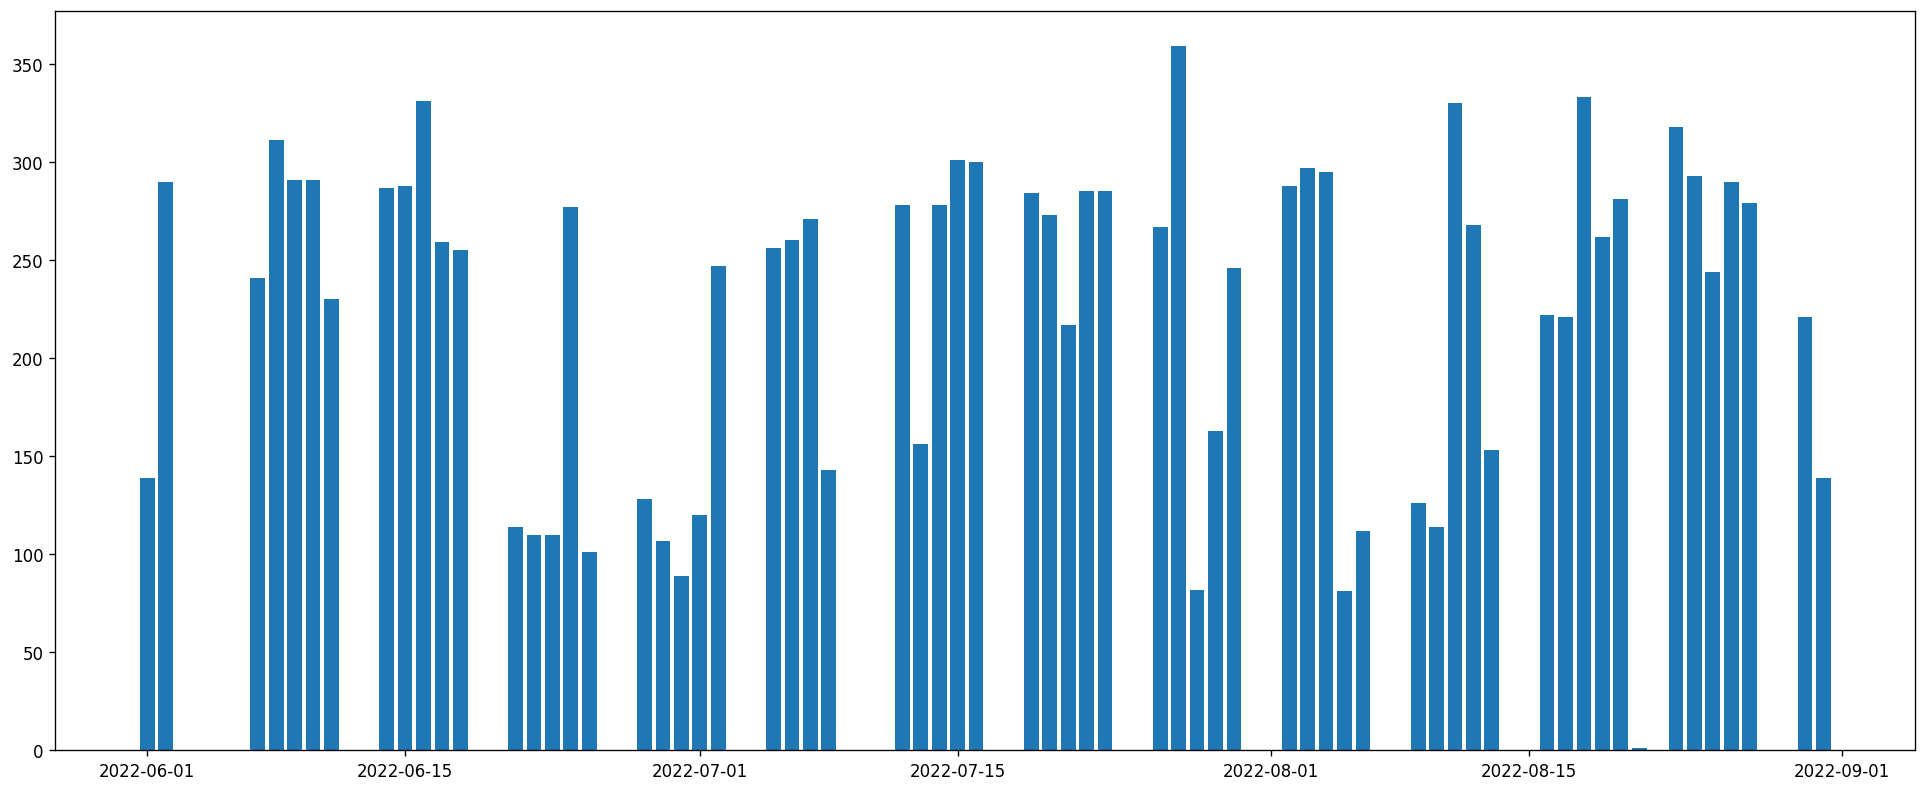

In [60]:
# volumes_totais_diarios['Volume'].plot(kind='bar', figsize = (15,8));
plt.rcParams["figure.figsize"] = (20,8)
plt.bar(volumes_totais_diarios['Data'], volumes_totais_diarios['Volume'])